In [1]:
from HeaderP import *
from scipy.interpolate import interp1d

In [5]:
def log_prior(params):
    m = params[0]
    return -1.5 * np.log(1 + m*m)

def log_marg_prob_scatter(params, S, yn, xn):
    m, b, log_lambda = params
    v = np.array([-m, 1.0])

    # Enforce the log-uniform prior on lambda. 
    if not -5.0 < log_lambda < 5.0:
        return -np.inf

    # Compute \Sigma^2 and \Delta.
    lamd = np.exp(log_lambda)
    Lambda = np.zeros((2,2))
    Lambda[0,0], Lambda[0,1], Lambda[1,0], Lambda[1,1] =  m**2, -m, -m, 1
    Lambda = Lambda * lamd**2/(1+m**2)
    Sigma2 = np.dot(np.dot(S+Lambda, v), v)
    Delta = m * xn + b - yn

    # Compute the log likelihood up to a constant.
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll + log_prior(params)

import emcee

def monoage(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5]):
    colors = getcolor(range(len(agebin)+1))
    plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        r_sing = r_sing[m2]
        feh_sing = feh_sing[m2]
        
        r_ave, feh_ave = movingMed_time(r_sing, feh_sing, 1, 0.1)
        #feh_ave = gaussian_filter(feh_ave, 4)
        """if agebin[i]==12.:
            plt.plot(r_sing, feh_sing,'.', color=colors[i], markersize=1)"""
        plt.plot(r_ave, feh_ave, color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.grid(color='grey', linestyle='-', linewidth=1)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)

def getscatt_bay(feh, r, age, feh_err, r_err, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    
    nwalkers=64
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    scatters_err = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    feherr = feh_err[m]
    rerr = r_err[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        feh_err_sing = feherr[m]
        r_err_sing = rerr[m]
        
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                #print(agebin[i], rbins[j], sum(m))
                print('not enough stars')
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                feh_err_sing_2 = feh_err_sing[m]
                r_err_sing_2 = r_err_sing[m]
        
                S = np.zeros((len(feh_sing_2),2,2))
                for k in range(len(feh_sing_2)):
                    S[k,0,0] = r_err_sing_2[k]**2
                    S[k,1,1] = feh_err_sing_2[k]**2
                print(agebin[i], rbins[j], len(feh_sing_2))
                z = np.polyfit(r_err_sing_2,feh_sing_2,1)
                sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(S, feh_sing_2, r_sing_2))
                p0 = np.array([z[0], z[1], np.log(0.03)])
                p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
                pos, _, _ = sampler_scatter.run_mcmc(p0, 1000, progress=True)
                sampler_scatter.reset()
                sampler_scatter.run_mcmc(pos, 6000, progress=True)
                samples_scatter = sampler_scatter.flatchain

                """# m
                mcmc = np.percentile(samples_scatter[:, 0], [16, 50, 84])
                q = np.diff(mcmc)
                hi_m[i,0], hi_m[i,1], hi_m[i,2] = mcmc[1], q[0], q[1]

                # b
                mcmc = np.percentile(samples_scatter[:, 1], [16, 50, 84])
                q = np.diff(mcmc)
                hi_b[i,0], hi_b[i,1], hi_b[i,2] = mcmc[1], q[0], q[1]"""

                # dispersion
                mcmc = np.percentile(samples_scatter[:, 2], [16, 50, 84])
                q = np.diff(mcmc)
                scatters[i,j], dishi, dislow = mcmc[1], q[0], q[1]
                scatters_err[i,j] = np.mean(abs(dishi)+abs(dislow))

                
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters, scatters_err


def getscatt(feh, r, age, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    if len(feherr)>0:
            feherr = feherr[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        if len(feherr)>0:
            feh_err_sing = feherr[m]
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                #print('not enough stars')
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                p = fitpoints(r_sing_2, feh_sing_2) 
                scatters[i,j] = np.std(feh_sing_2-p(r_sing_2))

                if len(feherr)>0:
                    feh_err_sing_2 = feh_err_sing[m]
                    scatters[i,j] = np.sqrt(scatters[i,j]**2-np.mean(feh_err_sing_2)**2)
                    #print(scatters[i,j])
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters
    
def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),
                feherr=[],xlims=[0,25],checkplt=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    

    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        if checkplt:
            plt.figure(figsize=(8,8))
            plt.plot(r_sing[m2], feh_sing[m2], 'r.')
            plt.plot(r_sing[m2], p(r_sing[m2]), 'k-',
                    label='%.2f Rb+%.2f'%(p[1],p[0]))
            plt.xlabel('Rb [kpc]')
            plt.ylabel('[Fe/H]')
            plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                     fontsize=25)
            plt.legend()

    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter
    
def getcolor(vrange, cmap=plt.cm.get_cmap('plasma')):
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    #print([cmap(norm(i)) for i in vrange])
    return [cmap(norm(i)) for i in vrange]


def avr(age, r, vz, rbin=np.linspace(6,12,4), agebin=np.linspace(0,14,10)):
    colors = getcolor(range(len(rbin)+1))
    avrs = np.zeros((len(rbin)-1, len(agebin)-1))
    for i in range(len(rbin)-1):
        m = (r>rbin[i])&(r<rbin[i+1])
        age_r, r_r, vz_r = age[m], r[m], vz[m]
        for j in range(len(agebin)-1):
            m2 = (age_r>agebin[j])&(age_r<agebin[j+1])
            if sum(m2)<50:
                avrs[i,j]=np.nan
            else:
                vz_r_age = vz_r[m2]
                avrs[i,j] = 1.5*sum(abs(vz_r_age-np.median(vz_r_age)))/sum(m2)
    return (agebin[:-1]+agebin[1:])/2, (rbin[:-1]+rbin[1:])/2, avrs
  

# Maosheng subgiant: https://www.nature.com/articles/s41586-022-04496-5

In [649]:
from astropy.table import Table
sub = Table.read('subgiant_fullparam_update.fits', format='fits')
sub = sub.to_pandas()
sub_rbir = pd.read_csv('RbirLAMOST.csv')
sub_rbir.columns

sub_rbir = sub_rbir.rename(columns={'          rb': 'Rb', 
                                    '          rb_err': 'Rb_err',
                                   '       specid':'specid'})
sub['SPECID'] = [str(i.decode(encoding="utf-8").split()[0]) for i in sub['SPECID']]
sub_rbir['specid'] = [str(i.split()[0]) for i in sub_rbir['specid']]

sub_rbir = pd.merge(sub, 
               sub_rbir[['specid', 'Rb', 'Rb_err']], 
               left_on='SPECID', right_on='specid', how='inner')
print(len(sub_rbir), len(sub))

200674 247104


In [650]:
len(sub)

247104

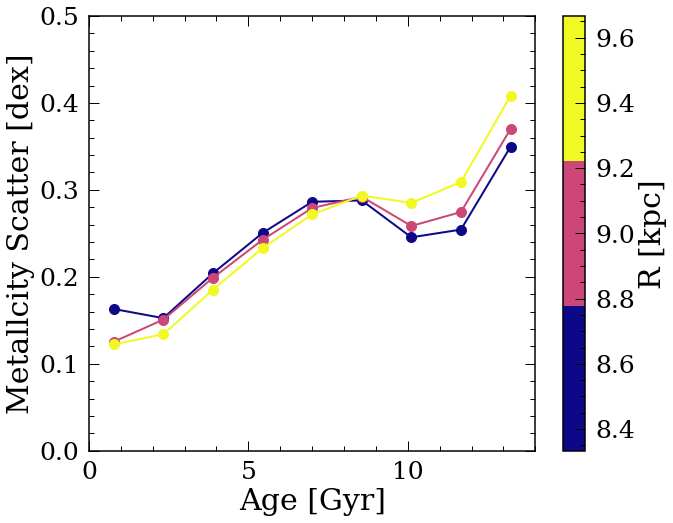

In [8]:
# scattering at different radius
m = (abs(sub['Z'])<1)
ages, rs, scatters = getscatt(sub['FEH'].values[m], 
                                        sub['R'].values[m], 
                                        sub['AGE'].values[m],
                                        agebin=np.linspace(0,14,10),
                                        xlims=[8,10],rbin=4,
                                       feherr=sub['FEH_ERR'].values[m])


colors = getcolor(rs)
plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, scatters[:,i], '-o', color=colors[i], markersize=10)
plt.scatter(-10,-10,c=0, vmin=min(rs), vmax=max(rs),
            cmap=plt.get_cmap('plasma', len(rs)))
cb = plt.colorbar()
cb.set_label('R [kpc]')
plt.xlabel('Age [Gyr]')
plt.ylabel('Metallcity Scatter [dex]')
plt.xlim([0,14])
plt.ylim([0,0.5])
plt.show()




In [61]:
"""xrange = [8.5,9.5]
agebincalc = np.linspace(0,16,17)
#zsel_scale = 2500
#Rsel_scale = 2500

############## define selection function
def sel_fn(z, mult, scale):
    return mult*np.exp(-abs(z)/scale)
############## define selection function



#sub = Table.read('subgiant_fullparam_update.fits', format='fits')
#sub = sub.to_pandas()

print('Before eccentricity cut:')
print(len(sub), len(sub_rbir))
sub_rbir = sub_rbir.loc[abs(sub_rbir['ECC'])<0.5].reset_index(drop=True)
sub = sub.loc[abs(sub['ECC'])<0.5].reset_index(drop=True)

print('After eccentricity cut:')
print(len(sub), len(sub_rbir))

sub_check = sub.loc[(sub['R']>xrange[0])&(sub['R']<xrange[1])]
m = (abs(sub_check['Z'])<1)&(sub_check['AGE_ERR']<np.diff(agebincalc)[0])
m = m&(sub_check['AGE']>1.5)

plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.plot(sub_check['R'][m], sub_check['Z'][m], 'k.', markersize=1)
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')

plt.subplot(1,2,2)
plt.scatter(sub_check['R'][m], sub_check['Z'][m], 
            c = sub_check['FEH'][m], s=4, cmap='plasma', vmin=-1,
           vmax=0.3)
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
cb = plt.colorbar()
cb.set_label('[Fe/H]')
plt.tight_layout()


##### select stars 
import random
m_sel = np.zeros(len(sub_check))
zbins = np.linspace(-2,2,100)
Rbins = np.linspace(xrange[0], xrange[1], 100)

zsel_scale = sum(abs(sub_check['Z'])<np.diff(zbins)[0])/2

for i in range(len(zbins)-1):
    m_sing = ((sub_check['Z'])>zbins[i])&((sub_check['Z'])<zbins[i+1])
    # number of stars to get
    nubstars = int(sel_fn((zbins[i]+zbins[i+1])/2, zsel_scale, 0.3))
    
    # get all the stars randomly
    randnum = list(range(sum(m_sing)))
    random.shuffle(randnum)
    random_ind = np.zeros(len(randnum))
    random_ind[randnum[:nubstars]] = 1
    
    m_sel[m_sing] = random_ind
m_sel = np.array(m_sel, dtype=bool)

# plot final histogram
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
(sub_check['Z']).hist(bins=zbins, color='k')
plt.plot((sub_check['Z']), sel_fn(sub_check['Z'], zsel_scale, 0.3), 'r.')
(sub_check['Z'][m_sel]).hist(bins=zbins, color='r')
plt.xlabel('z [kpc]')
plt.ylabel('Frequency')
plt.xlim([-2,2])

plt.subplot(1,2,2)
sub_check = sub_check[m_sel].reset_index(drop=True)
m_sel = np.zeros(len(sub_check))

Rsel_scale = sum((sub_check['R']>Rbins[0])&(sub_check['R']<Rbins[1]))/np.exp(-abs(xrange[0])/3.5)
print(zsel_scale, Rsel_scale)

for i in range(len(Rbins)-1):
    m_sing = (abs(sub_check['R'])>Rbins[i])&(abs(sub_check['R'])<Rbins[i+1])
    # number of stars to get
    nubstars = int(sel_fn((Rbins[i]+Rbins[i+1])/2, Rsel_scale, 3.5))
    
    # get all the stars randomly
    randnum = list(range(sum(m_sing)))
    random.shuffle(randnum)
    random_ind = np.zeros(len(randnum))
    random_ind[randnum[:nubstars]] = 1
    
    m_sel[m_sing] = random_ind
m_sel = np.array(m_sel, dtype=bool)

abs(sub_check['R']).hist(bins=Rbins, color='k')
plt.plot(abs(sub_check['R']), 
         sel_fn(sub_check['R'], Rsel_scale, 3.5), 'r.')
abs(sub_check['R'][m_sel]).hist(bins=Rbins, color='r')
plt.xlabel('R [kpc]')
plt.ylabel('Frequency')
plt.tight_layout()




### final final histogram
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
(sub_check['Z'][m_sel]).hist(bins=zbins, color='k')
plt.plot((sub_check['Z'][m_sel]), 
         sel_fn(sub_check['Z'][m_sel], 
                sum(abs(sub_check['Z'][m_sel])<zbins[1])/2, 0.3), 'r.')
plt.xlabel('z [kpc]')
plt.ylabel('Frequency')
plt.xlim([-2,2])

plt.subplot(1,2,2)
abs(sub_check['R'][m_sel]).hist(bins=Rbins, color='k')
plt.plot(abs(sub_check['R'][m_sel]), 
         sel_fn(sub_check['R'][m_sel], Rsel_scale, 3.5), 'r.')
plt.xlabel('R [kpc]')
plt.ylabel('Frequency')
plt.tight_layout()
print(sum(m_sel))



#### plot R-z 
plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.plot(sub_check['R'][m_sel], sub_check['Z'][m_sel], 'k.', markersize=1)
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
plt.plot(xrange, [0, 0], 'b--', linewidth=3)

plt.subplot(1,2,2)
plt.scatter(sub_check['R'][m_sel], sub_check['Z'][m_sel], 
            c = sub_check['FEH'][m_sel], s=4, cmap='plasma', vmin=-1,
           vmax=0.3)
plt.plot(xrange, [0, 0], 'b--', linewidth=3)
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
cb = plt.colorbar()
cb.set_label('[Fe/H]')
plt.tight_layout()



#### get slope for selected sample
ages, slopes, fehscatter = monoage_line(sub_check['FEH'].values[m_sel], 
                                        sub_check['R'].values[m_sel], 
                                        sub_check['AGE'].values[m_sel],
                                        agebin=agebincalc,
                                        xlims=xrange,
                                       feherr=sub_check['FEH_ERR'].values[m_sel],
                                       plotlegend=False,pltfig=False)

(sub_check[m_sel].reset_index(drop=True)).to_csv('Xiang_fitline.csv',index=False)

sub_check = sub_check[m_sel].reset_index(drop=True)
print('full sample', len(sub_check))
print(max(sub_check['AGE']))
sub_check = pd.merge(sub_check, 
                     pd.read_csv('Xiang_elements.csv')[['MG_FE','MG_FE_ERR','SPECID']],
                    left_on='SPECID', right_on='SPECID',how='inner')
sub_check = sub_check.loc[abs(sub_check['MG_FE'])<100].dropna(subset=['MG_FE','MG_FE_ERR']).reset_index(drop=True)
print('with [Mg/Fe]', len(sub_check))
print(max(sub_check['AGE']))


ages_afe, slopes_afe, fehscatter_afe = monoage_line(sub_check['MG_FE'].values, 
                                        sub_check['R'].values, 
                                        sub_check['AGE'].values,
                                        agebin=agebincalc,
                                        xlims=xrange,
                                       feherr=sub_check['MG_FE_ERR'].values,
                                       plotlegend=False,pltfig=False)



sub_check = sub_rbir.loc[abs(sub_rbir['Z'])<1]
sub_check = sub_check.loc[(sub_check['AGE_ERR']<np.diff(agebincalc)[0])]
sub_check = sub_check.loc[(sub_check['AGE']>1.5)].reset_index(drop=True)

ages, slopes_rbir, fehscatter_rbir = monoage_line(sub_check['FEH'].values, 
                                        sub_check['Rb'].values, 
                                        sub_check['AGE'].values,
                                        agebin=agebincalc,
                                        xlims=[0,15],
                                       feherr=sub_check['FEH_ERR'].values,
                                       plotlegend=False,pltfig=False)


ivanslope = pd.read_csv('rb_slope.csv')
ivanslope_int = interp1d(np.append(ivanslope['t_model    '].values, 16),
                        np.append(ivanslope['      slope'].values, 
                                  ivanslope['      slope'].values[-1]),
                         kind='cubic')
slopes_rbir = ivanslope_int(ages)


#sub_check = sub_check.dropna(subset=['ALPHA_FE','ALPHA_FE_ERR'])
sub_check = pd.merge(sub_check, 
                     pd.read_csv('Xiang_elements.csv')[['MG_FE','MG_FE_ERR','SPECID']],
                    left_on='SPECID', right_on='SPECID',how='inner')
sub_check = sub_check.loc[abs(sub_check['MG_FE'])<100].dropna(subset=['MG_FE','MG_FE_ERR']).reset_index(drop=True)



ages_afe, slopesafe_rbir, fehscatterafe_rbir = monoage_line(sub_check['MG_FE'].values, 
                                        sub_check['Rb'].values, 
                                        sub_check['AGE'].values,
                                        agebin=agebincalc,
                                        xlims=[0,15],
                                       feherr=sub_check['MG_FE_ERR'].values,
                                       plotlegend=False,pltfig=False)

plt.figure(figsize=(8,8))
plt.plot(ages, slopes, 'r-o')
plt.plot(ages, slopes_rbir, 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('Metallicity Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.3, 0.2])

plt.twinx()
plt.plot(ages, fehscatter, 'b-o')
plt.ylim([0.,0.4])
plt.ylabel('Metallicity Scatter', color='b',zorder=5)


"""

"xrange = [8.5,9.5]\nagebincalc = np.linspace(0,16,17)\n#zsel_scale = 2500\n#Rsel_scale = 2500\n\n############## define selection function\ndef sel_fn(z, mult, scale):\n    return mult*np.exp(-abs(z)/scale)\n############## define selection function\n\n\n\n#sub = Table.read('subgiant_fullparam_update.fits', format='fits')\n#sub = sub.to_pandas()\n\nprint('Before eccentricity cut:')\nprint(len(sub), len(sub_rbir))\nsub_rbir = sub_rbir.loc[abs(sub_rbir['ECC'])<0.5].reset_index(drop=True)\nsub = sub.loc[abs(sub['ECC'])<0.5].reset_index(drop=True)\n\nprint('After eccentricity cut:')\nprint(len(sub), len(sub_rbir))\n\nsub_check = sub.loc[(sub['R']>xrange[0])&(sub['R']<xrange[1])]\nm = (abs(sub_check['Z'])<1)&(sub_check['AGE_ERR']<np.diff(agebincalc)[0])\nm = m&(sub_check['AGE']>1.5)\n\nplt.figure(figsize=(20,9))\nplt.subplot(1,2,1)\nplt.plot(sub_check['R'][m], sub_check['Z'][m], 'k.', markersize=1)\nplt.xlabel('R [kpc]')\nplt.ylabel('z [kpc]')\n\nplt.subplot(1,2,2)\nplt.scatter(sub_check['R'

# Use range to determine slope

### [Fe/H]

In [430]:
def monoage_line_range(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[], plotlegend=True, pltfig=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    if pltfig:
        plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            slopes[i] = np.nan
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            slopes[i] = np.nan
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] =np.percentile(feh_sing[m2],95)-np.percentile(feh_sing[m2],5)
        #fehscatter[i] = ave_inf(((agebin[i]+agebin[i+1])/2))-(np.percentile(feh_sing[m2],5))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        if pltfig:
            plt.plot(r_sing[m2], p(r_sing[m2]), color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    if pltfig:
        if plotlegend:
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
        plt.xlabel('R [kpc]')
        plt.ylabel('[Fe/H]')
        plt.xlim(xlims)
        plt.ylim(ylims)
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter



def monoage_line_range_mc(feh,r,age,feh_err, r_err, age_err,
                          agebin=np.linspace(0,14,8),xlims=[6,12],
                          ylims=[-1.5,0.5],feherr=[], mcmc=100):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    fehscatter_err = np.zeros(len(agebin)-1)
    
    fehscatterall = np.zeros((mcmc,len(agebin)-1))*np.nan
  
    for j in trange(mcmc):
        age_new = np.array([np.random.normal(age[k], age_err[k]) for k in range(len(age))], dtype=float)
        r_new = np.array([np.random.normal(r[k], r_err[k]) for k in range(len(r))], dtype=float)
        feh_new = np.array([np.random.normal(feh[k], feh_err[k]) for k in range(len(feh))], dtype=float)

        
        for i in range(len(agebin)-1):
            m = (age_new>agebin[i])&(age_new<agebin[i+1])
            if sum(m)==0:
                fehscatterall[j,i] = np.nan
                continue
            r_sing, feh_sing = zip(*sorted(zip(r_new[m], feh_new[m])))
            r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)

            m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
            if sum(m2)==0:
                fehscatterall[j,i] = np.nan
                continue
            fehscatterall[j,i] =np.percentile(feh_sing[m2],95)-np.percentile(feh_sing[m2],5)
    
    fehscatter = [np.median(fehscatterall[:,k]) for k in range(len(agebin)-1)]
    fehscatter_err = [np.std(fehscatterall[:,k]) for k in range(len(agebin)-1)]
    
    return (agebin[:-1]+agebin[1:])/2, fehscatter, fehscatter_err


In [1384]:
xrange = [8.5,9.5]
agebincalc = np.linspace(0,16,17)
zsel_scale = 2500
Rsel_scale = 2500 
sub_rbir = sub_rbir.loc[abs(sub_rbir['ECC'])<0.5].reset_index(drop=True)
sub = sub.loc[abs(sub['ECC'])<0.5].reset_index(drop=True)

#sub_check = pd.read_csv('Xiang_fitline.csv')
sub = Table.read('subgiant_fullparam_update.fits', format='fits')
sub = sub.to_pandas()
sub_check = sub.loc[abs(sub['Z'])<0.5]
print(np.diff(agebincalc)[0])
sub_check = sub_check.loc[sub_check['AGE_ERR']<np.diff(agebincalc)[0]]
sub_check = sub_check.loc[abs(sub_check['ECC'])<0.5]
sub_check = sub_check.loc[sub_check['FEH_ERR']<0.05].reset_index(drop=True)
#sub_check = sub_check.loc[sub_check['AGE_ERR']<0.5].reset_index(drop=True)

print(len(sub_check))
ages, slopes_range, fehscatter_range = monoage_line_range(sub_check['FEH'].values, 
                                        sub_check['R_GUIDING'].values, 
                                        sub_check['AGE'].values,
                                        agebin=agebincalc,
                                        xlims=[7,10],
                                       plotlegend=False,pltfig=False)

sub_check['R_err'] = (sub_check['PARALLAX'])**-2*(sub_check['PARALLAX_ERROR'])


ages, fehscatter_mcmc, fehscatter_mcmc_err = monoage_line_range_mc(sub_check['FEH'].values, 
                                        sub_check['R_GUIDING'].values, 
                                        sub_check['AGE'].values,
                                        sub_check['FEH_ERR'].values, 
                                        sub_check['R_err'].values, 
                                        sub_check['AGE_ERR'].values,
                                        agebin=agebincalc,
                                        xlims=[7,10],
                                       feherr=sub_check['FEH_ERR'].values,
                                                                  mcmc=100)

1.0
52761


"ages, fehscatter_mcmc, fehscatter_mcmc_err = monoage_line_range_mc(sub_check['FEH'].values, \n                                        sub_check['R_GUIDING'].values, \n                                        sub_check['AGE'].values,\n                                        sub_check['FEH_ERR'].values, \n                                        sub_check['R_err'].values, \n                                        sub_check['AGE_ERR'].values,\n                                        agebin=agebincalc,\n                                        xlims=[7,10],\n                                       feherr=sub_check['FEH_ERR'].values,\n                                                                  mcmc=100)"

In [426]:
df_slopesave = pd.DataFrame(np.array((ages, fehscatter_mcmc, fehscatter_mcmc_err)).T,
            columns=['age', 'fehscatter', 'fehscatter_err'])
ivanslope = pd.read_csv('rb_slope_etc.csv')
print(ivanslope.columns)
ivanslope_int = interp1d(np.append(ivanslope['t_model'].values, 16),
                        np.append(ivanslope[' slope_old'].values, 
                                  ivanslope[' slope_old'].values[-1]),
                         kind='cubic')
df_slopesave['slopes_rbir'] = ivanslope_int(df_slopesave['age'])
df_slopesave.to_csv('data_slopps.csv', index=False)

Index(['t_model', ' slope_old', ' slope_new', ' feh_sol_old', ' feh_sol_new',
       ' feh_gc'],
      dtype='object')


In [1419]:
"""tmax = 15
scaln = 0.1
infslopes = np.zeros(len(ivanslope[' slope_old']))
infslopes = (np.log(tmax-ivanslope['t_model'])*scaln+(-0.07-scaln*np.log(tmax)))
infslopes[ivanslope['t_model']>tmax] = min(infslopes)
ivanslope[' slope_old'] = infslopes

plt.figure(figsize=(8,8))
#plt.plot(ivanslope['t_model'], ivanslope[' slope_old'], 'k-')


print(ivanslope.columns)
ivanslope_int = interp1d(np.append(ivanslope['t_model'].values, 16),
                        np.append(ivanslope[' slope_old'].values, 
                                  ivanslope[' slope_old'].values[-1]),
                         kind='cubic')
slopes_rbir = ivanslope_int(ages)

x = slopes_rbir

plt.scatter(x, fehscatter_range, 
           c=ages, s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', len(df)))

ages_calc = ages[1:9]
def slopecalc(scatter, a):
    #alpha = abs(alpha)
    a = abs(a)
    return 1/a*(ages_calc)**(-0.5)*scatter-0.07-scatter/a

from scipy.optimize import curve_fit
popt, pcov = curve_fit(slopecalc, fehscatter_range[1:9], x[1:9])


def slopecalc(scatter, a):
    #alpha = abs(alpha)
    a = abs(a)
    ages_calc = ages[1:]
    return 1/a*(ages_calc)**(-0.5)*scatter-0.07-scatter/a

plt.plot(slopecalc(fehscatter_range[1:], *popt), fehscatter_range[1:],
        "k-o")
print(popt)

#plt.plot(slopecalc(fehscatter_range[1:], 0.39, 0.5), fehscatter_range[1:])"""

'tmax = 15\nscaln = 0.1\ninfslopes = np.zeros(len(ivanslope[\' slope_old\']))\ninfslopes = (np.log(tmax-ivanslope[\'t_model\'])*scaln+(-0.07-scaln*np.log(tmax)))\ninfslopes[ivanslope[\'t_model\']>tmax] = min(infslopes)\nivanslope[\' slope_old\'] = infslopes\n\nplt.figure(figsize=(8,8))\n#plt.plot(ivanslope[\'t_model\'], ivanslope[\' slope_old\'], \'k-\')\n\n\nprint(ivanslope.columns)\nivanslope_int = interp1d(np.append(ivanslope[\'t_model\'].values, 16),\n                        np.append(ivanslope[\' slope_old\'].values, \n                                  ivanslope[\' slope_old\'].values[-1]),\n                         kind=\'cubic\')\nslopes_rbir = ivanslope_int(ages)\n\nx = slopes_rbir\n\nplt.scatter(x, fehscatter_range, \n           c=ages, s=300, edgecolor=\'k\', \n            cmap=plt.get_cmap(\'plasma\', len(df)))\n\nages_calc = ages[1:9]\ndef slopecalc(scatter, a):\n    #alpha = abs(alpha)\n    a = abs(a)\n    return 1/a*(ages_calc)**(-0.5)*scatter-0.07-scatter/a\n\nfrom scipy

In [1421]:
"""plt.hexbin(sub['AGE'], sub['FEH'])
plt.twinx()
plt.plot(ages[1:], slopecalc(fehscatter_range[1:], *popt),'r-o')
df['slope_rbir_infer'] = np.append([-0.07],(slopecalc(fehscatter_range[1:], *popt)))
plt.plot(ivanslope['t_model'], ivanslope[' slope_old'], 'r--')
plt.plot(0,-0.07,'ro')"""

"plt.hexbin(sub['AGE'], sub['FEH'])\nplt.twinx()\nplt.plot(ages[1:], slopecalc(fehscatter_range[1:], *popt),'r-o')\ndf['slope_rbir_infer'] = np.append([-0.07],(slopecalc(fehscatter_range[1:], *popt)))\nplt.plot(ivanslope['t_model'], ivanslope[' slope_old'], 'r--')\nplt.plot(0,-0.07,'ro')"

Index(['t_model', ' slope_old', ' slope_new', ' feh_sol_old', ' feh_sol_new',
       ' feh_gc'],
      dtype='object')
-0.12462798802360349


/opt/homebrew/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


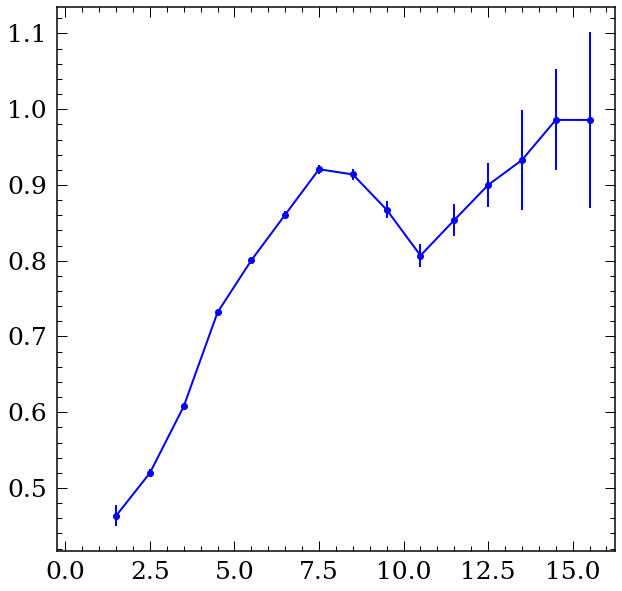

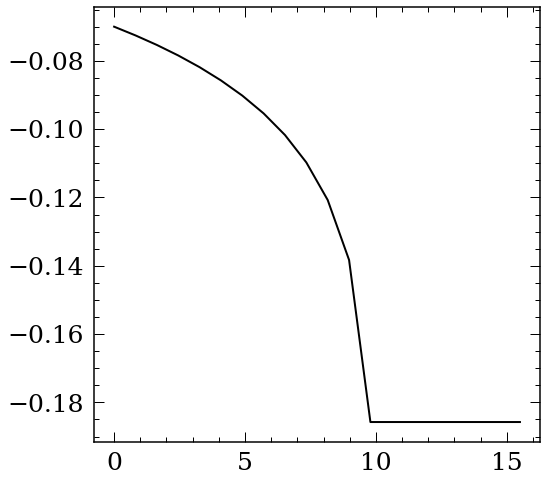

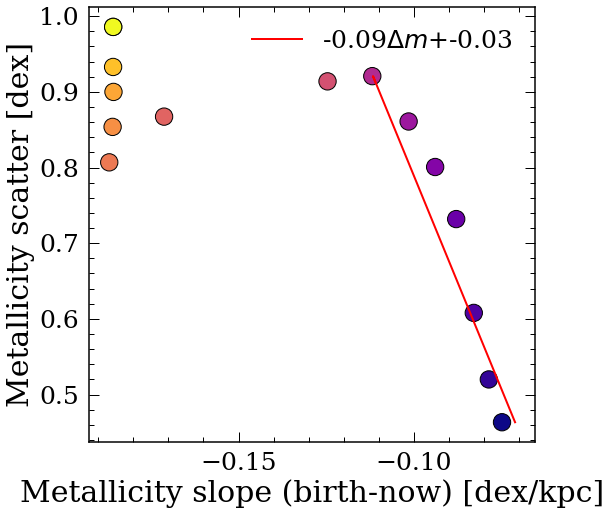

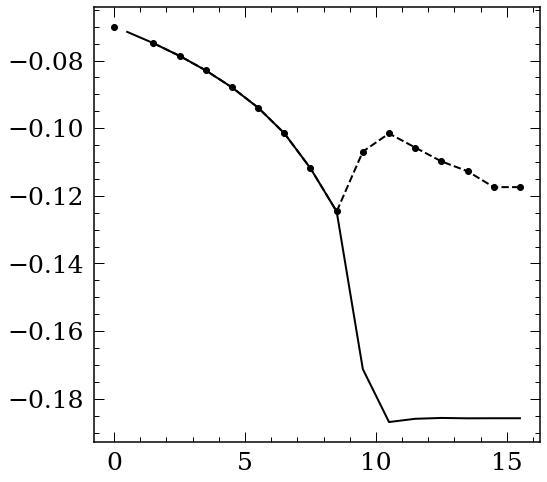

In [1638]:
#m1 = -(fehscatter_range-9.5*abs(slopes))/7.5

plt.figure()
ages, fehscatter_range = np.array(ages,dtype=float), np.array(fehscatter_mcmc,dtype=float)
#plt.plot(ages, fehscatter_range, 'b-o')
plt.errorbar(ages, fehscatter_mcmc, yerr=fehscatter_mcmc_err, fmt='b-o')
df = df_slopesave


ivanslope = pd.read_csv('rb_slope_etc.csv')


infslopes = np.zeros(len(ivanslope[' slope_old']))
infslopes = (np.log(10-ivanslope['t_model'])*0.03+(-0.07-0.03*np.log(10)))
infslopes[ivanslope['t_model']>10] = min(infslopes)
ivanslope[' slope_old'] = infslopes

plt.figure(figsize=(8,8))
plt.plot(ivanslope['t_model'], ivanslope[' slope_old'], 'k-')


print(ivanslope.columns)
ivanslope_int = interp1d(np.append(ivanslope['t_model'].values, 16),
                        np.append(ivanslope[' slope_old'].values, 
                                  ivanslope[' slope_old'].values[-1]),
                         kind='cubic')
slopes_rbir = ivanslope_int(ages)
df['slopes_rbir'] = slopes_rbir
x = slopes_rbir

m2 = (ages<9)&(x==x)
m2 = m2&(fehscatter_range==fehscatter_range)

plt.figure(figsize=(8,8))
plt.scatter(x, fehscatter_range, 
           c=ages, s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', len(df)))

p = fitpoints(fehscatter_range[m2], x[m2])
#p[1] = p[1]-0.07
#p[0] = p[0]+0.028

plt.xlabel('Metallicity slope (birth-now) [dex/kpc]')
plt.ylabel('Metallicity scatter [dex]')
plt.plot(p(fehscatter_range)[m2],
         (fehscatter_range)[m2], 'r-', 
         label="%.2f$Δm$+%.2f"%(p[1],p[0]))
plt.legend()

slope_rbir_infer = np.zeros(len(fehscatter_range))
#slope_rbir_infer =p((fehscatter_range))
slope_rbir_infer[~m2] =p((fehscatter_range[~m2]))
slope_rbir_infer[m2] = slopes_rbir[m2]



df['slope_rbir_infer'] = slope_rbir_infer
print(min(df['slope_rbir_infer'].dropna()))

plt.figure(figsize=(8,8))
plt.plot(ages, slopes_rbir, 'k-')
plt.plot(ages, slope_rbir_infer, 'k--o')
plt.plot(0,-0.07,'ko')
#plt.plot(ages, m1, 'b--o')

df.to_csv('data_slopps.csv', index=False)



# use inferred slope to get Rbir


In [1607]:
def getRb(age, feh, func_m, func_b):
    Rb = np.zeros(len(age))
    for i in trange(len(age)):
        m = func_m(age[i])
        b = func_b(age[i])
        #y = m*8.2
        #b = b-y
        
        Rb[i] = (feh[i]-b)/m
    return Rb
        

    

In [1608]:
# get Fe/H in solar neiborhood
agebins = np.linspace(0,16,17)
fehave = np.zeros(len(agebins)-1)
fehave_age = np.zeros(len(agebins)-1)
for i in range(len(agebins)-1):
    sub_sing = sub_rbir.loc[(sub_rbir['AGE']>agebins[i])&(sub_rbir['AGE']<agebins[i+1])]
    sub_sing = sub_sing.loc[abs(sub_sing['Rb']-8.2)<0.5]
    fehave[i] = np.median(sub_sing['FEH'].dropna())
fehave_age = (agebins[1:]+agebins[:-1])/2
    
    
fehevl = pd.read_table('feh_t_sol.txt', delim_whitespace=True,
                      names=['0','1'])
fehave_age, fehave = fehevl['0'].values, fehevl['1'].values

fehave = fehave+0.075*8.2

/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


"agebins = np.linspace(0,16,17)\nfehave_age = (agebins[1:]+agebins[:-1])/2\n\n\nplt.figure(figsize=(8,8))\nplt.plot(np.linspace(0,100,100), \n         newfunc(np.linspace(0,100,100)), 'k-')\n\nplt.figure(figsize=(8,8))\nplt.hexbin(sub['AGE'], sub['FEH'], cmap=plt.get_cmap('binary',15), \n           extent=(0,16,-1,0.5), )\n\n#plt.plot(fehave_age, fehave, 'r-o')\n\nplt.plot(fehave_age, newfunc(fehave_age), 'r-o')\n\n\n\nfehave = newfunc(fehave_age)"

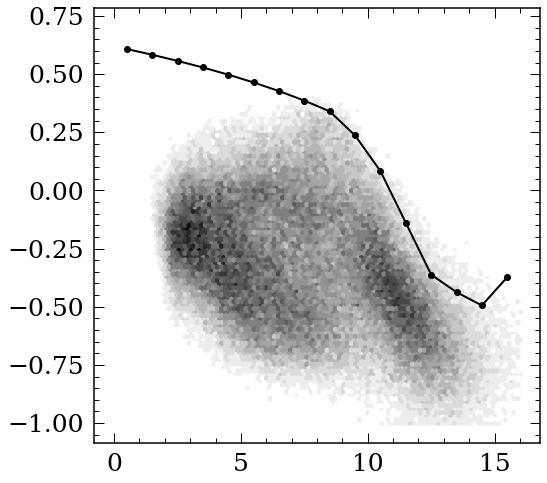

In [1620]:
rgcut = 5
#base = 17
base = 15


def newfunc(age):
    return np.log((16-(age)))/np.log(base)-(np.log(16)/np.log(base)-0.72)

# getting moving median for the most metal rich stars
agebins = np.linspace(0,16,17)
avefeh = np.zeros(len(agebins)-1)
for i in range(len(agebins)-1):
    metalrich = sub.loc[(sub['AGE']>agebins[i])&(sub['AGE']<agebins[i+1])]
    metalrich = metalrich.loc[metalrich['R_GUIDING']<rgcut]
    metalrich = metalrich.loc[metalrich['AGE_ERR']<np.diff(agebins)[0]]
    metalrich = metalrich.loc[metalrich['FEH_ERR']<0.03]
    #metalrich = metalrich.loc[metalrich['R']<5]
    #print(len(metalrich))
    if (agebins[i]+agebins[i+1])/2 > 9:
        avefeh[i] = (np.percentile(metalrich['FEH'],99.5))
        #avefeh[i] = (max(metalrich['FEH']))
    else:
        avefeh[i] = newfunc((agebins[i]+agebins[i+1])/2)

    
fehave_age = (agebins[1:]+agebins[:-1])/2
fehave = avefeh-0.1

#fehave[fehave_age==3.5] = fehave[fehave_age==3.5]

fehave[(fehave_age==15.5)] += 0.2


"""ivan = pd.read_csv('rb_slope_etc.csv')
fehave_age = ivan['t_model'].values
fehave = ivan[' feh_gc'].values"""
plt.figure(figsize=(8,8))
plt.plot(fehave_age, fehave, 'k-o', zorder=100)

sub_smallrg = sub.loc[sub['R_GUIDING']<rgcut]
#plt.plot(sub_smallrg['AGE'], sub_smallrg['FEH'],'bo',markersize=1)

#plt.scatter(sub_smallrg['AGE'], sub_smallrg['FEH'],
#           c=sub_smallrg['FEH_ERR'])
#plt.hexbin(sub_smallrg['AGE'], sub_smallrg['FEH'], cmap=plt.get_cmap('binary',15), 
#           extent=(0,16,-1,0.7))


plt.hexbin(sub['AGE'], sub['FEH'], cmap=plt.get_cmap('binary',15), 
           extent=(0,16,-1,0.7))

"""agebins = np.linspace(0,16,17)
avefeh = np.zeros(len(agebins)-1)
for i in range(len(agebins)-1):
    metalrich = sub.loc[(sub['AGE']>agebins[i])&(sub['AGE']<agebins[i+1])]
    #metalrich = metalrich.loc[metalrich['R']<5]
    #print(len(metalrich))
    if (agebins[i]+agebins[i+1])/2 > 0:
        avefeh[i] = np.median(np.percentile(metalrich['FEH'],5))
    else:
        avefeh[i] = newfunc((agebins[i]+agebins[i+1])/2)

    
fehave_age = (agebins[1:]+agebins[:-1])/2
fehave_low = avefeh

plt.plot(fehave_age, fehave, 'r-o')
plt.plot(fehave_age, fehave_low, 'r-o')



plt.xlim([0,16])
plt.ylim([-1,0.7])

plt.twinx()
plt.plot(fehave_age, fehave-fehave_low, 'b-o')"""



"""agebins = np.linspace(0,16,17)
fehave_age = (agebins[1:]+agebins[:-1])/2


plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,100,100), 
         newfunc(np.linspace(0,100,100)), 'k-')

plt.figure(figsize=(8,8))
plt.hexbin(sub['AGE'], sub['FEH'], cmap=plt.get_cmap('binary',15), 
           extent=(0,16,-1,0.5), )

#plt.plot(fehave_age, fehave, 'r-o')

plt.plot(fehave_age, newfunc(fehave_age), 'r-o')



fehave = newfunc(fehave_age)"""

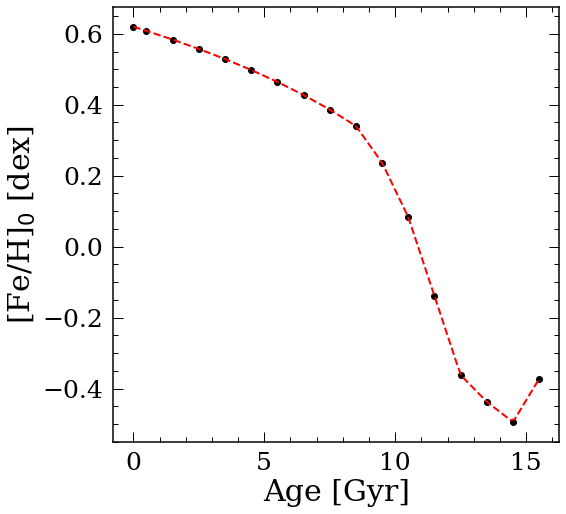

In [1623]:

plt.figure(figsize=(8,8))
mfit = (fehave==fehave)
ave_inf = interp1d(np.append([0],fehave_age[mfit]), 
                   np.append([0.62],fehave[mfit]), kind='linear')
fehave = ave_inf(df['age'])
plt.plot(df['age'], fehave, 'ko')
plt.plot(0,0.62,'ko')
plt.plot(np.linspace(0,15.5,100), ave_inf(np.linspace(0,15.5,100)), 'r--')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]$_{0}$ [dex]')
df['feh_cor'] = ave_inf(df['age'])




15
-0.09537152353302047 -0.19656549394130707


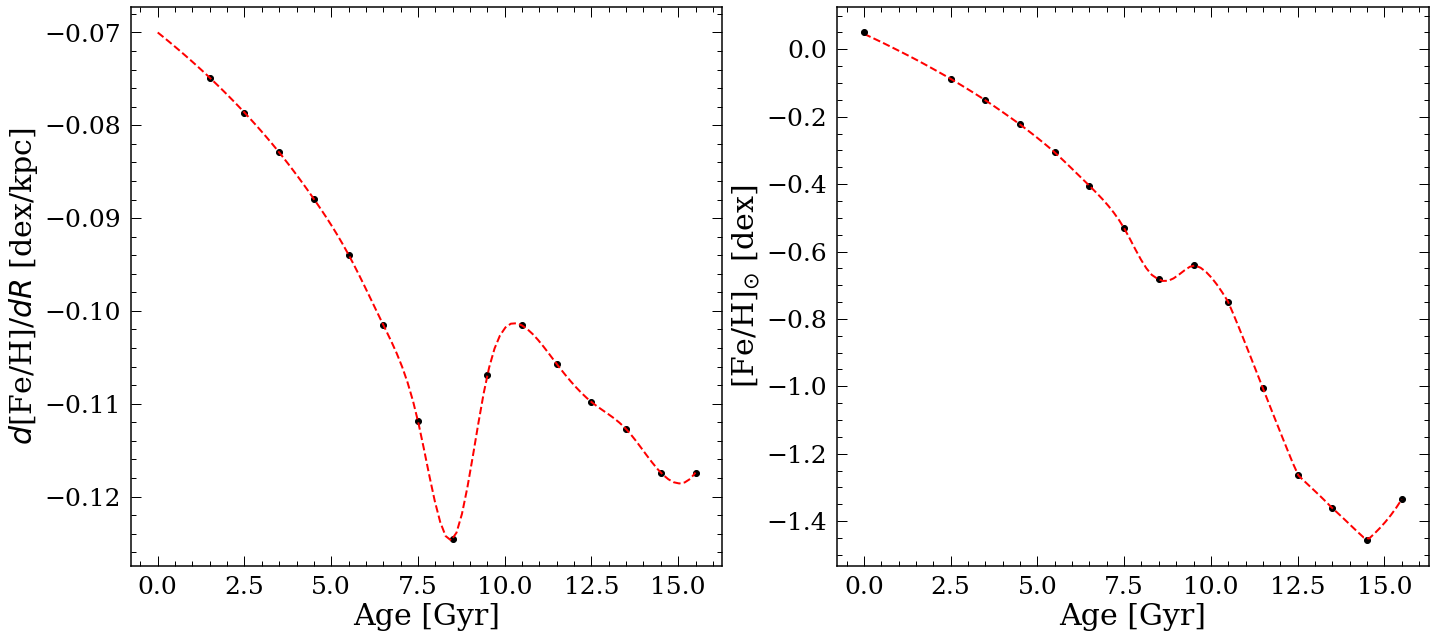

In [1637]:
from scipy.interpolate import interp1d

mfit = (df['slope_rbir_infer']==df['slope_rbir_infer'])
print(sum(mfit))

slope_inf = interp1d(np.append([0],df['age'][mfit]), 
                     np.append([-0.07],df['slope_rbir_infer'][mfit]), 
                     kind='cubic')


"""ivanslope['slope_cor'] = np.nan
m = (ivanslope['t_model    ']>1.5)
ivanslope['slope_cor'][m] = slope_inf(ivanslope['t_model    '][m])
m2 = (df['age'][mfit]>12)


ivanslope['feh_cor'] = np.nan
m = (ivanslope['t_model    ']>1.5)
ivanslope['feh_cor'][m] = ave_inf(ivanslope['t_model    '][m])
m2 = (df['age'][mfit]>12)
ivanslope_ext = df[mfit][m2][['age', 'slope_rbir_infer','feh_cor']]
ivanslope_ext = ivanslope_ext.rename(columns={'slope_rbir_infer':'slope_cor',
                             'age':'t_model    '})
ivanslope = pd.merge(ivanslope, ivanslope_ext, how='outer')
ivanslope.sort_values('t_model    ').to_csv('rb_slope2.csv', index=False)"""


plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.plot(df['age'][mfit], df['slope_rbir_infer'][mfit], 'ko')
#plt.plot(ivanslope['t_model    '], ivanslope['slope_cor'], 'bo')
plt.plot(np.linspace(0,15.5,100), slope_inf(np.linspace(0,15.5,100)), 'r--')
plt.xlabel('Age [Gyr]')
plt.ylabel('$d$[Fe/H]/$dR$ [dex/kpc]')
#plt.vlines(12, ymin=-0.1, ymax=-0.06, color='k')


plt.subplot(1,2,2)
m = (fehave_age>1.5)&(fehave_age<=15.5)
plt.plot(fehave_age[m], slope_inf(fehave_age[m])*8.2+ave_inf(fehave_age[m]), 'ko')
plt.plot(np.linspace(0,15.5,100), 
         slope_inf(np.linspace(0,15.5,100))*8.2+ave_inf(np.linspace(0,15.5,100)), 'r--')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]$_{\odot}$ [dex]')
plt.plot(0,0.1-0.05,'ko')
plt.tight_layout()

print(slope_inf(2.5)*8.3+ave_inf(2.5), np.mean(sub.loc[abs(sub['AGE']-2.5)<0.1]['FEH']))

pd.DataFrame(np.array((df['age'], fehave, df['slope_rbir_infer'].values)).T,
            columns=['age','feh_cor','slope_cor']).to_csv('slopes_cor.csv',index=False)


In [1627]:
#len(fehave_age), len(fehave), len(df['slope_rbir_infer'].values)

In [1628]:
sub_tryRb = sub.loc[(sub['AGE']>0)&(sub['AGE']<15)].reset_index(drop=True)
sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['R']-8.178)<0.5].reset_index(drop=True)
sub_tryRb['Rb_new'] = getRb(sub_tryRb['AGE'].values, sub_tryRb['FEH'].values, slope_inf, ave_inf)


100%|██████████| 89764/89764 [00:03<00:00, 27344.37it/s]


In [1629]:
print(np.mean(sub_tryRb['Rb_new']))

5.356947306778412


8.180122011012395
0.022882224499799476


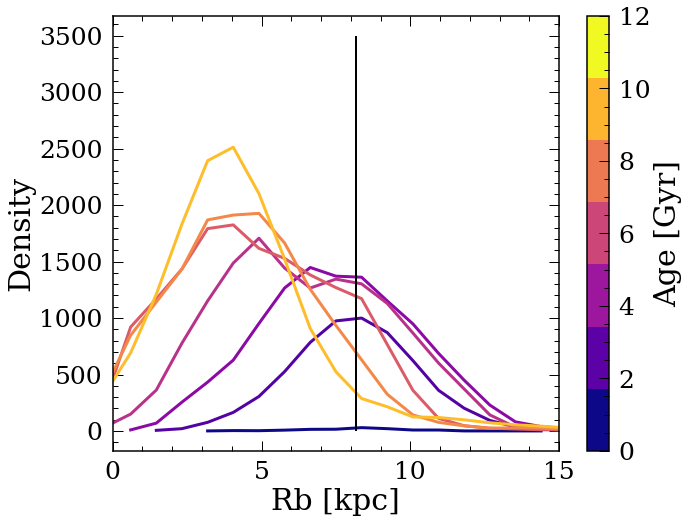

In [1630]:
agebin_Rb = np.linspace(0,12,8)
agebin_colors = getcolor(agebin_Rb)
plt.figure(figsize=(10,8))
#plt.hist(sub_tryRb['Rb'], color='k', alpha=0.2, bins=np.linspace(0,20,100))
for i in range(len(agebin_Rb)-1):
    sub_sing = sub_tryRb.loc[(sub_tryRb['AGE']>agebin_Rb[i])&(sub_tryRb['AGE']<agebin_Rb[i+1])]
    fre, edg = np.histogram(sub_sing['Rb_new'], bins=np.linspace(-5,20,30), density=False)
    
    m = (fre!=0)
    plt.plot((edg[1:]+edg[:-1])[m]/2, fre[m], color=agebin_colors[i], linewidth=3)
    if i==0:
        print(np.mean(sub_sing['Rb_new']))
    """plt.vlines(np.mean(sub_sing['Rb_new']), ymin=0, ymax=800, color=agebin_colors[i],
              linewidth=3)"""
#plt.vlines(8.2, ymin=0, ymax=900, color='k')
plt.scatter(100,0,c=5,vmin=min(agebin_Rb),vmax=max(agebin_Rb),
           cmap=plt.get_cmap('plasma', len(agebin_Rb)-1))
plt.xlim([0,15])
plt.xlabel('Rb [kpc]')
plt.ylabel('Density')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.vlines(8.178,0,3500, color='k')
print(sum(sub_tryRb['Rb_new']<0)/len(sub_tryRb['Rb_new']))


In [1631]:
sub_tryRb = sub.loc[(sub['AGE']>0)&(sub['AGE']<=15)].reset_index(drop=True)
sub_tryRb['Rb_new'] = getRb(sub_tryRb['AGE'].values, sub_tryRb['FEH'].values, slope_inf, ave_inf)



100%|██████████| 240266/240266 [00:09<00:00, 26201.87it/s]


0.024970143919384225


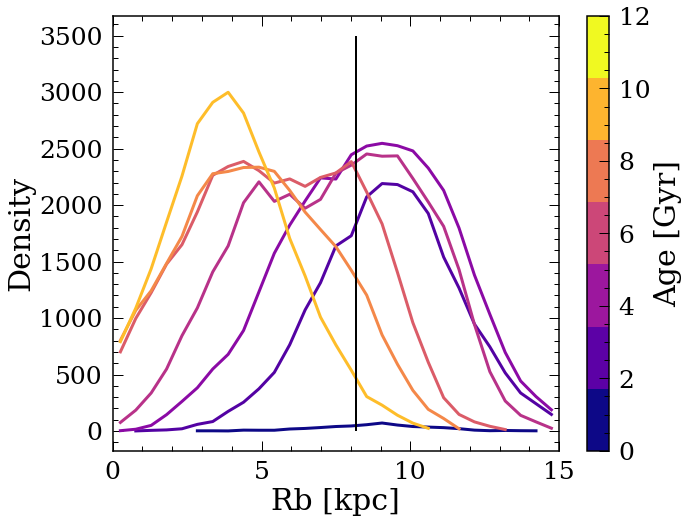

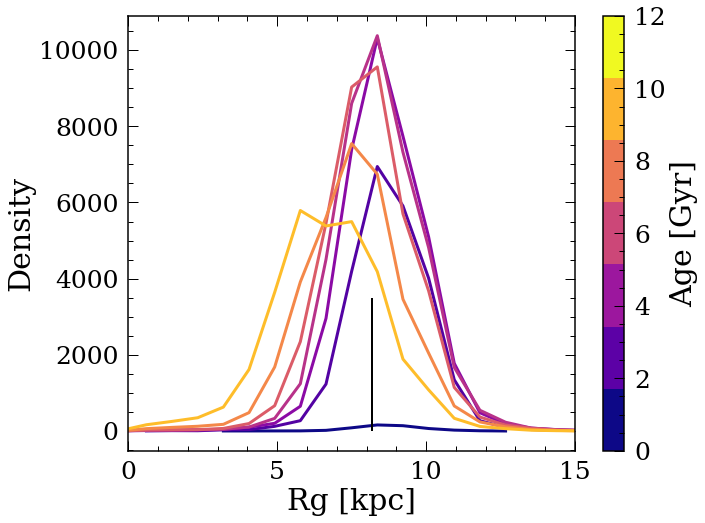

In [1632]:
agebin_Rb = np.linspace(0,12,8)
agebin_colors = getcolor(agebin_Rb)
plt.figure(figsize=(10,8))
sub_tryRb = sub_tryRb.loc[sub_tryRb['FEH']>-1]
#plt.hist(sub_tryRb['Rb'], color='k', alpha=0.2, bins=np.linspace(0,20,100))
for i in range(len(agebin_Rb)-1):
    sub_sing = sub_tryRb.loc[(sub_tryRb['AGE']>agebin_Rb[i])&(sub_tryRb['AGE']<agebin_Rb[i+1])]
    fre, edg = np.histogram(sub_sing['Rb_new'], bins=np.linspace(0,15,30), density=False)
    
    m = (fre!=0)
    plt.plot((edg[1:]+edg[:-1])[m]/2, fre[m], color=agebin_colors[i], linewidth=3)
    
    """plt.vlines(np.mean(sub_sing['Rb_new']), ymin=0, ymax=800, color=agebin_colors[i],
              linewidth=3)"""
#plt.vlines(8.2, ymin=0, ymax=900, color='k')
plt.scatter(100,0,c=5,vmin=min(agebin_Rb),vmax=max(agebin_Rb),
           cmap=plt.get_cmap('plasma', len(agebin_Rb)-1))
plt.vlines(8.178,0,3500, color='k')
plt.xlim([0,15])
plt.xlabel('Rb [kpc]')
plt.ylabel('Density')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')


plt.figure(figsize=(10,8))
for i in range(len(agebin_Rb)-1):
    sub_sing = sub_tryRb.loc[(sub_tryRb['AGE']>agebin_Rb[i])&(sub_tryRb['AGE']<agebin_Rb[i+1])]
    fre, edg = np.histogram(sub_sing['R_GUIDING'], bins=np.linspace(-5,20,30), density=False)
    
    m = (fre!=0)
    plt.plot((edg[1:]+edg[:-1])[m]/2, fre[m], color=agebin_colors[i], linewidth=3)
    
    """plt.vlines(np.mean(sub_sing['Rb_new']), ymin=0, ymax=800, color=agebin_colors[i],
              linewidth=3)"""
#plt.vlines(8.2, ymin=0, ymax=900, color='k')
plt.scatter(100,0,c=5,vmin=min(agebin_Rb),vmax=max(agebin_Rb),
           cmap=plt.get_cmap('plasma', len(agebin_Rb)-1))
plt.vlines(8.178,0,3500, color='k')
plt.xlim([0,15])
plt.xlabel('Rg [kpc]')
plt.ylabel('Density')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')


print(sum(sub_tryRb['Rb_new']<0)/len(sub_tryRb['Rb_new']))



In [1633]:
sub_tryRb['Rb'] = sub_tryRb['Rb_new']
sub_tryRb.to_pickle('NewRb.pkl')
#sub_tryRb.to_pickle('NewRb_dip.pkl')

### Check [$\alpha$/Fe]

In [1634]:
def monoage_line_alpha(feh,r,age,agebin=np.linspace(0,14,8),
                feherr=[],xlims=[0,25],checkplt=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    

    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        xlims = [np.mean(r_sing)-np.std(r_sing), np.mean(r_sing)+np.std(r_sing)]
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        if checkplt:
            plt.figure(figsize=(8,8))
            plt.plot(r_sing[m2], feh_sing[m2], 'r.')
            plt.plot(r_sing[m2], p(r_sing[m2]), 'k-',
                    label='%.2f Rb+%.2f'%(p[1],p[0]))
            plt.xlabel('Rb [kpc]')
            plt.ylabel('[Fe/H]')
            plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                     fontsize=25)
            plt.legend()

    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter


6.539631463509308 3.350549573762761


 56%|█████▋    | 9/16 [00:03<00:02,  2.76it/s]<ipython-input-5-fd1cc949c820>:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,8))
100%|██████████| 16/16 [00:05<00:00,  2.94it/s]


"ages_afe, fehscatter_afe, fehscatter_afe_err = monoage_line_range_mc(sub_check['ALPHA_FE'].values, \n                                        sub_check['R_GUIDING'].values, \n                                        sub_check['AGE'].values,\n                                        sub_check['ALPHA_FE_ERR'].values, \n                                        sub_check['R_err'].values, \n                                        sub_check['AGE_ERR'].values,\n                                        agebin=agebincalc,\n                                        xlims=[7,10],mcmc=100)"

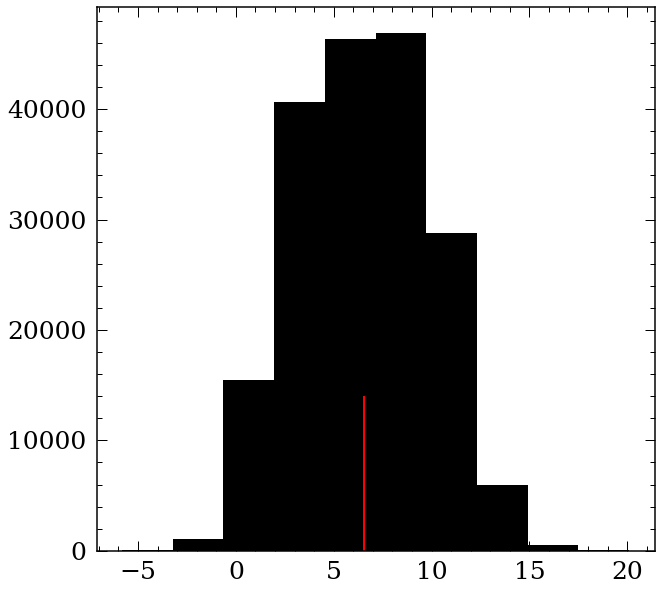

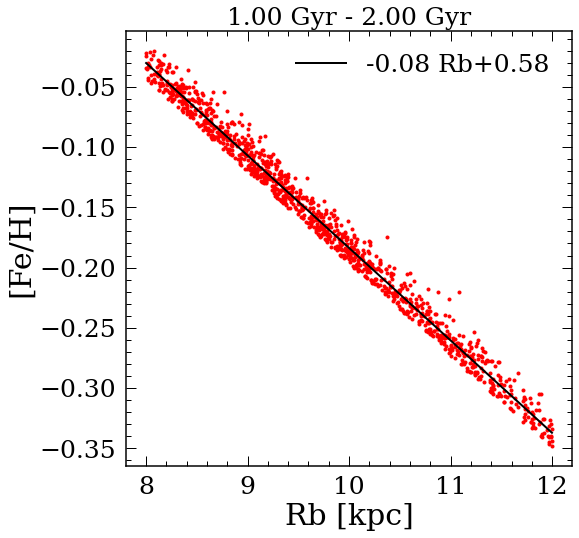

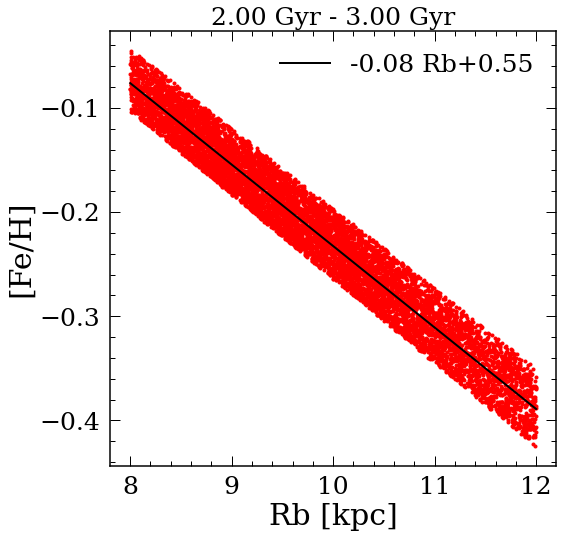

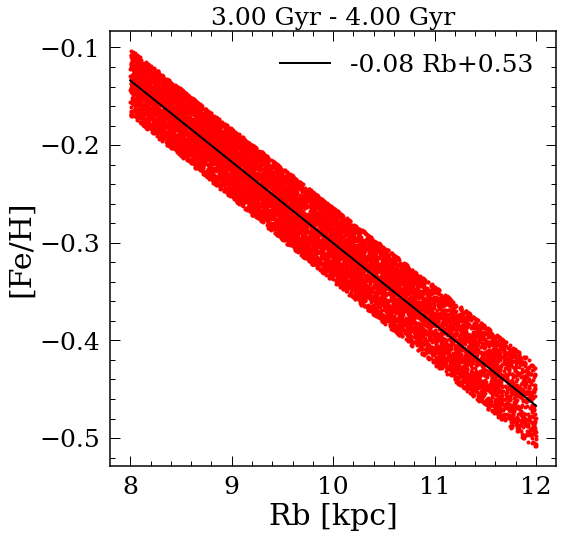

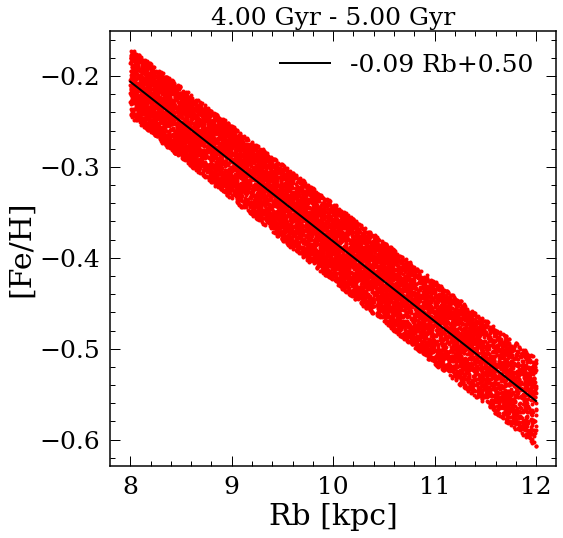

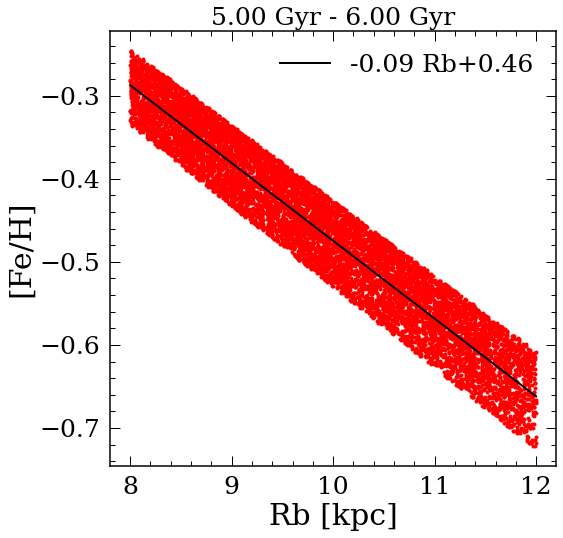

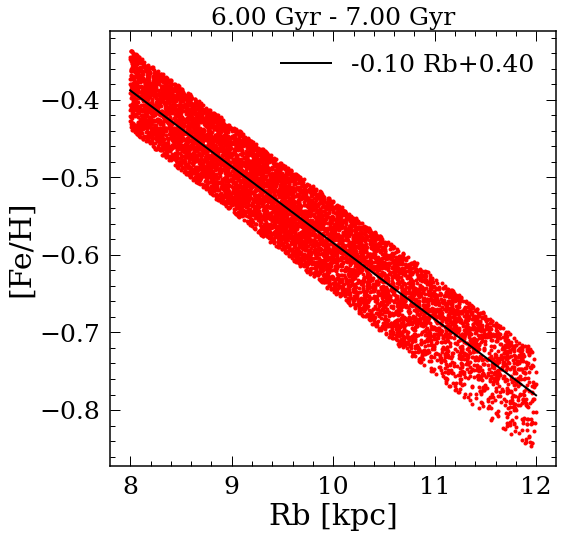

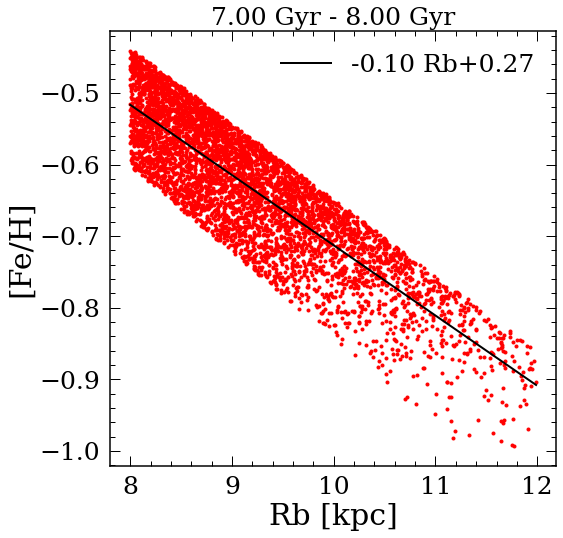

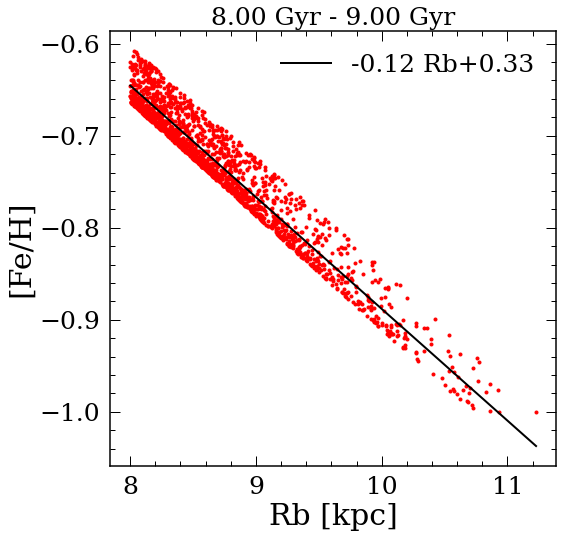

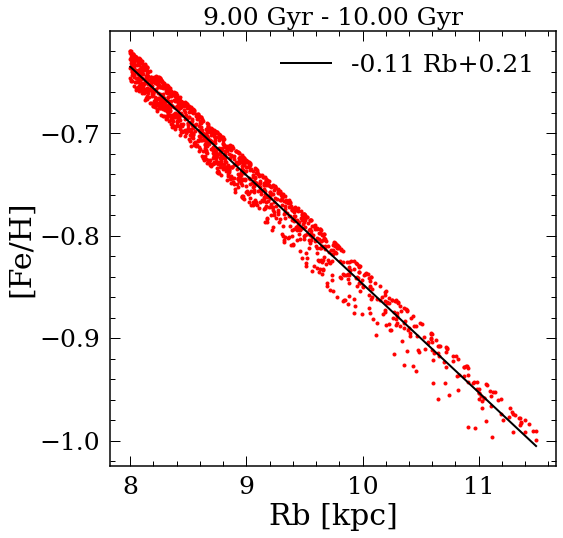

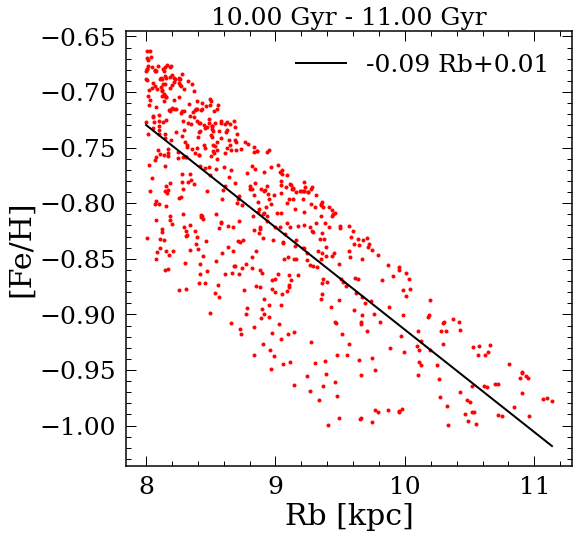

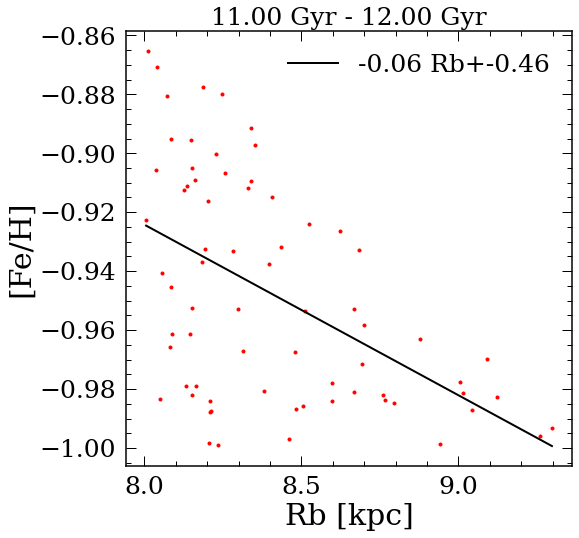

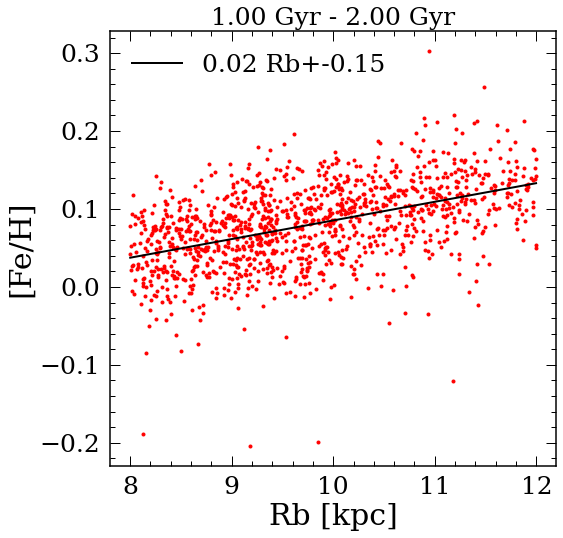

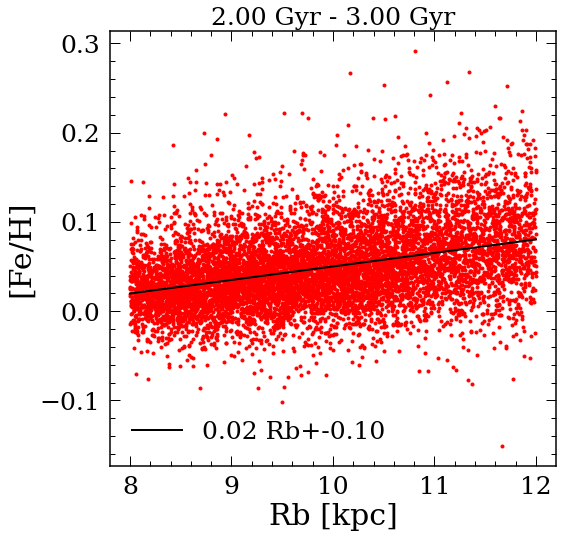

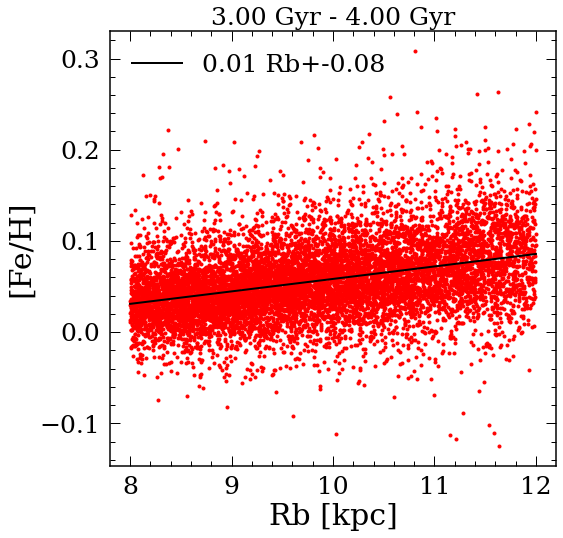

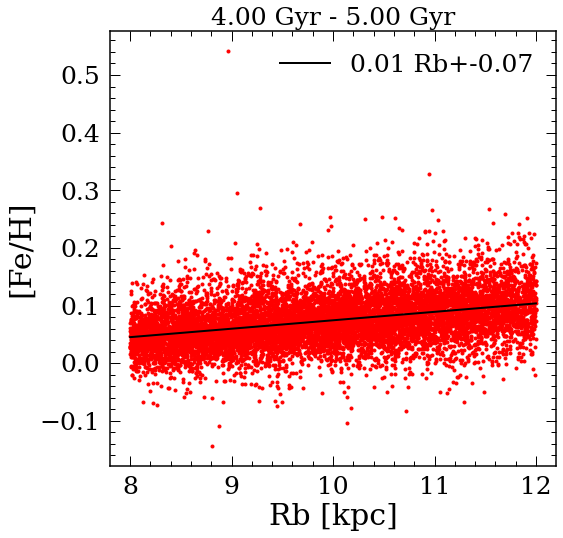

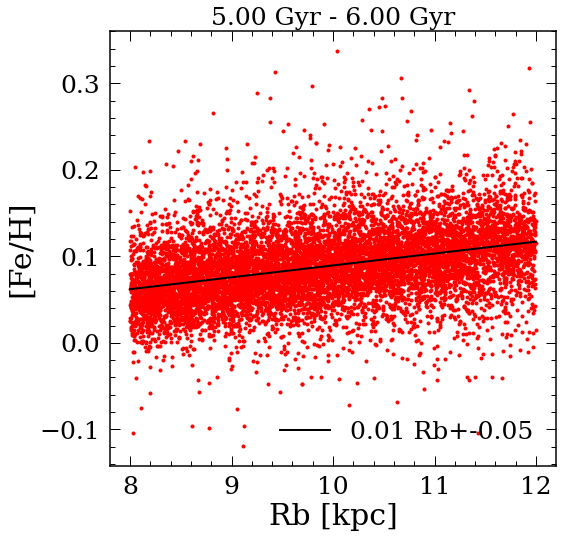

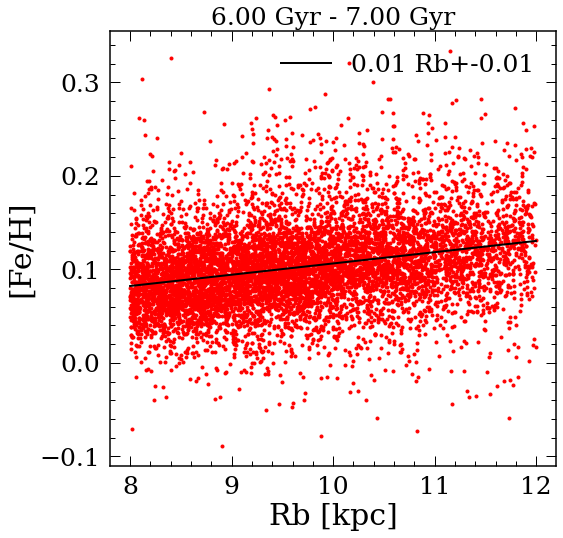

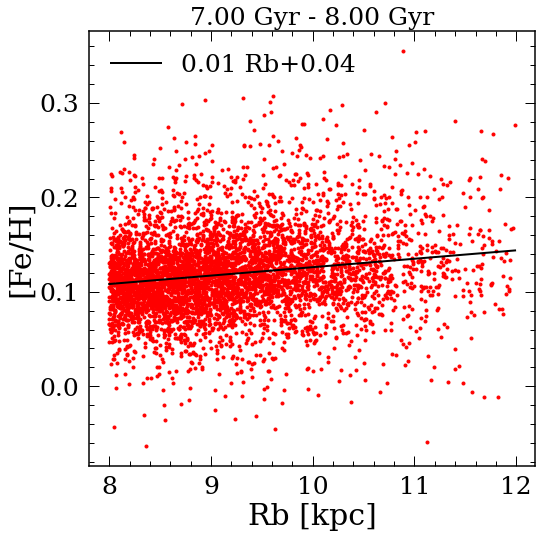

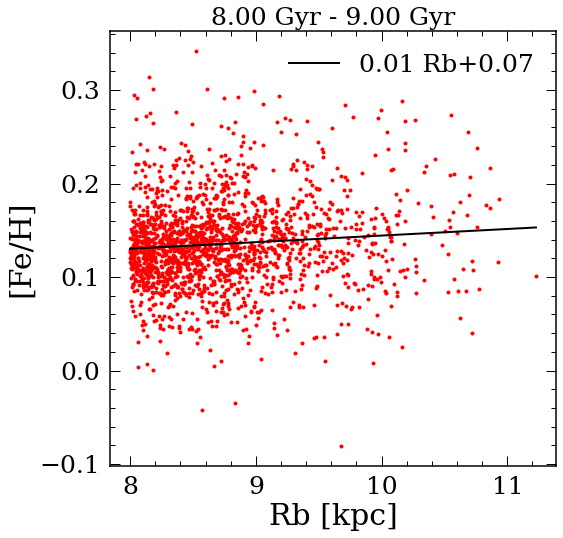

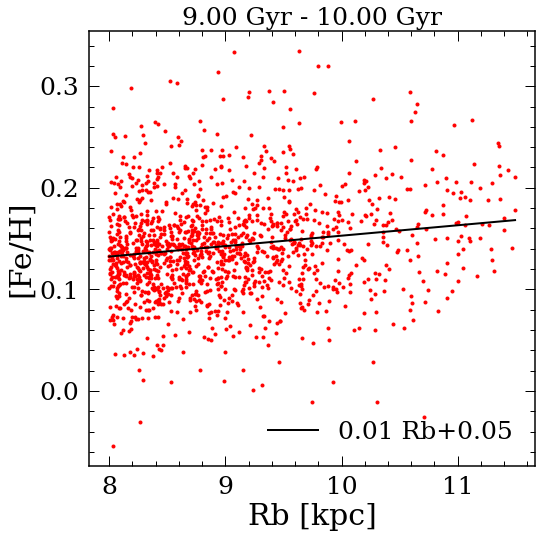

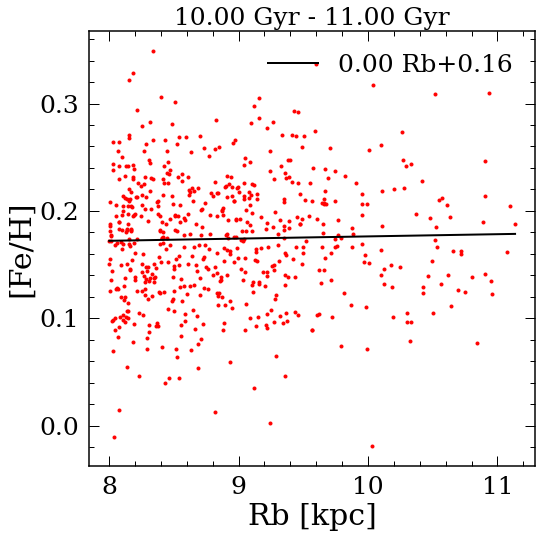

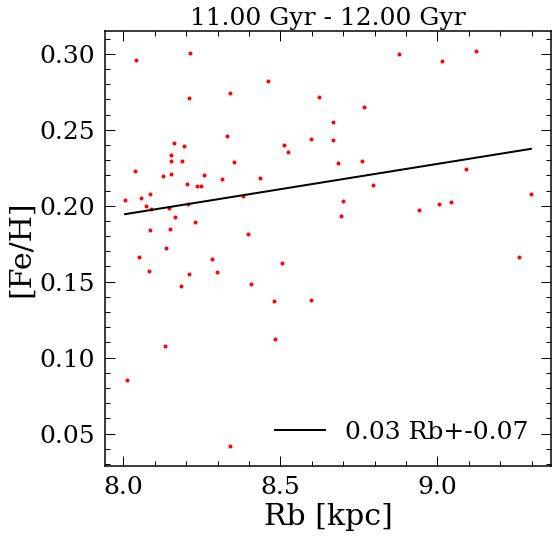

In [1657]:
#sub_tryRb['Rb'] = sub_tryRb['Rb_new']

from scipy.interpolate import interp1d
agefit = 15
sub_tryRb = sub_tryRb.dropna(subset=['Rb','AGE','ALPHA_FE'])
sub_tryRb_sel = sub_tryRb.loc[sub_tryRb['AGE_ERR']<np.diff(agebincalc)[0]]
sub_tryRb_sel = sub_tryRb_sel.loc[sub_tryRb_sel['ALPHA_FE_ERR']<0.1]
sub_tryRb_sel = sub_tryRb_sel.loc[sub_tryRb_sel['FEH']>-1]
#sub_tryRb_sel = sub_tryRb_sel.loc[abs(sub_tryRb_sel['Z'])<0.5]

#df = pd.read_csv('Xiang_selslope_afe.csv')
ages_afe, slopes_afe, fehscatter_afe = monoage_line_range(sub_tryRb_sel['ALPHA_FE'].values, 
                                        sub_tryRb_sel['R_GUIDING'].values, 
                                        sub_tryRb_sel['AGE'].values,
                                        agebin=agebincalc,
                                        xlims=[7,10],
                                       plotlegend=False,pltfig=False)


plt.hist(sub_tryRb_sel['Rb'].values, color='k')
plt.vlines(np.median(sub_tryRb_sel['Rb'].values), ymin=0, ymax=14000, color='r')
print(np.median(sub_tryRb_sel['Rb'].values), np.std(sub_tryRb_sel['Rb'].values))

medrb = np.median(sub_tryRb_sel['Rb'].values)
stdrb = np.std(sub_tryRb_sel['Rb'].values)

#xlims = [medrb-stdrb,medrb+stdrb]
xlims = [8,12]
ages_afe, slopesafe_rbir, fehscatterrb_afe = monoage_line(sub_tryRb_sel['FEH'].values, 
                                        sub_tryRb_sel['Rb'].values, 
                                        sub_tryRb_sel['AGE'].values,
                                        agebin=agebincalc,
                                        xlims=xlims)



#sub_tryRb = sub_rbir.dropna(subset=['Rb','AGE','ALPHA_FE'])
#sub_tryRb_sel = sub_rbir.loc[sub_rbir['AGE_ERR']<np.diff(agebincalc)[0]]
#sub_tryRb_sel = sub_tryRb_sel.loc[sub_tryRb_sel['ALPHA_FE_ERR']<0.1]
#sub_tryRb_sel = sub_tryRb_sel.loc[sub_tryRb_sel['FEH']>-1]
ages_afe, slopesafe_rbir, fehscatterrb_afe = monoage_line(sub_tryRb_sel['ALPHA_FE'].values, 
                                        sub_tryRb_sel['Rb'].values, 
                                        sub_tryRb_sel['AGE'].values,
                                        agebin=agebincalc,
                                        xlims=xlims)

"""ages_afe, fehscatter_afe, fehscatter_afe_err = monoage_line_range_mc(sub_check['ALPHA_FE'].values, 
                                        sub_check['R_GUIDING'].values, 
                                        sub_check['AGE'].values,
                                        sub_check['ALPHA_FE_ERR'].values, 
                                        sub_check['R_err'].values, 
                                        sub_check['AGE_ERR'].values,
                                        agebin=agebincalc,
                                        xlims=[7,10],mcmc=100)"""


(-0.8720119252773946, 0.002174276849000326)


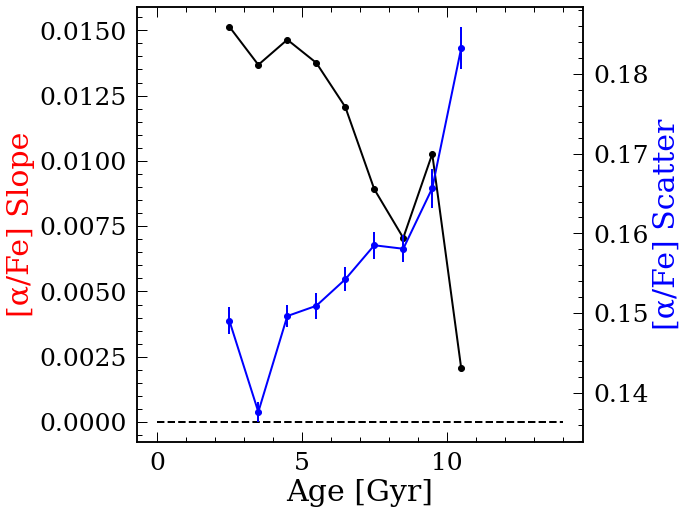

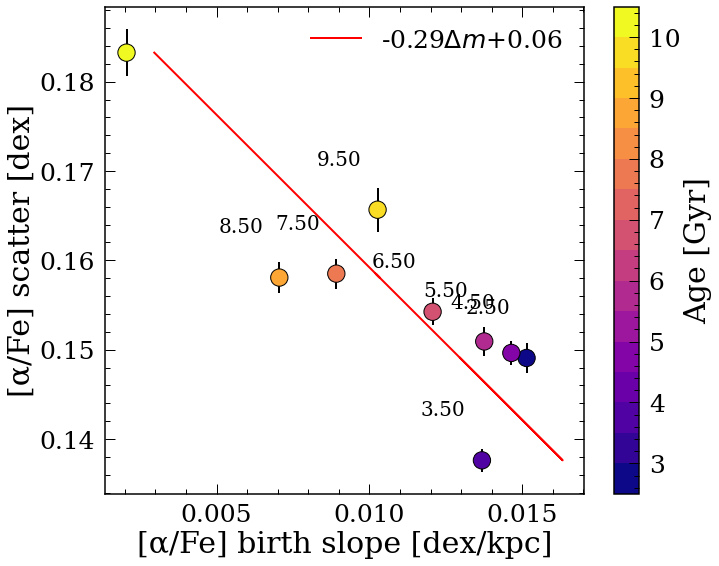

In [1661]:
plt.figure(figsize=(8,8))
maxageshow=11
#plt.errorbar(ages_afe, slopes_afe, fmt='r--o')
m2 = (ages_afe>2)&(ages_afe<maxageshow)
plt.plot(ages_afe[m2], slopesafe_rbir[m2], 'k-o',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
#plt.ylim([-0.15, 0.05])

plt.twinx()
#plt.errorbar(ages_afe, fehscatter_afe, yerr=fehscatterafe_err, fmt='b-o')
plt.errorbar(ages_afe[m2], fehscatter_afe[m2], yerr=fehscatter_afe_err[m2], fmt='b-o')
#plt.ylim([0.,0.1])
plt.ylabel('[α/Fe] Scatter', color='b',zorder=5)


df_afe = pd.DataFrame(np.array((ages_afe, slopes_afe, fehscatter_afe, slopesafe_rbir,
                               fehscatterrb_afe)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir','fehscatter_rbir'])


df_afe = df_afe.dropna(subset=['slopes','fehscatter']).reset_index(drop=True)

df_afe['slopes_rbir'] = df_afe['slopes_rbir']
m2 = (ages>2)&(ages<maxageshow)

slopesafe_rbir, fehscatter_afe, fehscatter_afe_err = np.array(slopesafe_rbir,dtype=float), np.array(fehscatter_afe,dtype=float), np.array(fehscatter_afe_err,dtype=float)

plt.figure(figsize=(10,8))
plt.scatter(slopesafe_rbir[m2], fehscatter_afe[m2], 
           c=ages[m2], s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', len(df)),zorder=10)
plt.errorbar(slopesafe_rbir[m2], fehscatter_afe[m2], 
             yerr=fehscatter_afe_err[m2], fmt='ko',zorder=-1)

p = fitpoints(fehscatter_afe[m2], slopesafe_rbir[m2])
plt.xlabel('[α/Fe] birth slope [dex/kpc]')
plt.ylabel('[α/Fe] scatter [dex]')
plt.plot(p(fehscatter_afe)[m2],
         (fehscatter_afe)[m2], 'r-', 
         label="%.2f$Δm$+%.2f"%(p[1],p[0]))

n = ages[m2]
for i, txt in enumerate(n):
    plt.annotate('%.2f'%txt, (slopesafe_rbir[m2][i]-0.002, fehscatter_afe[m2][i]+0.005), 
                 fontsize=20,color='k')
plt.tight_layout()

cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.legend()

from scipy import stats
m3 = (ages[m2]<12)
print(stats.pearsonr(fehscatter_afe[m2][m3], slopesafe_rbir[m2][m3]))

df_afe = pd.DataFrame(np.array((ages_afe, fehscatter_afe, fehscatter_afe_err,
                                      slopesafe_rbir)).T,
            columns=['age', 'fehscatter', 'fehscatter_err','slopes_rbir'])
df_afe.to_csv('data_slopps_afe.csv', index=False)



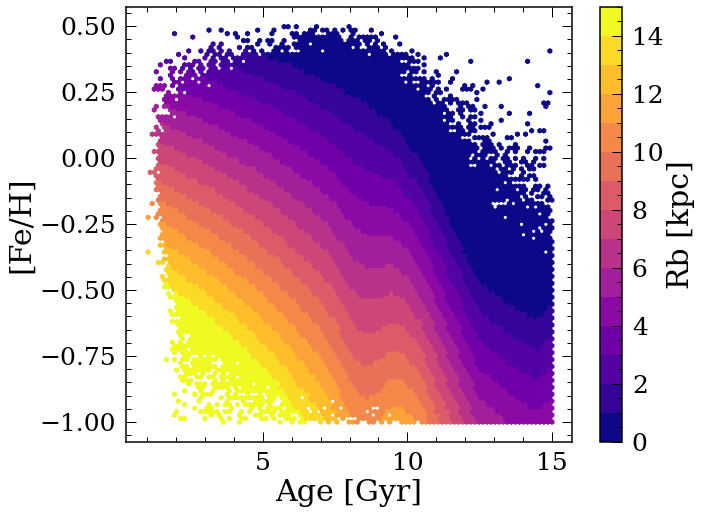

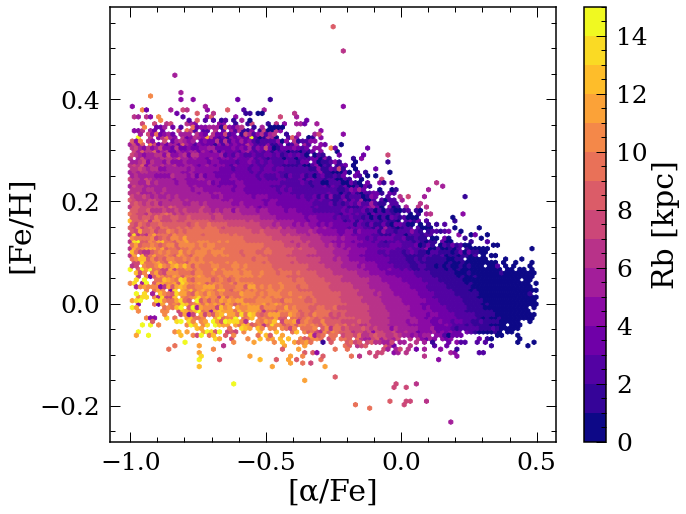

In [1662]:
plt.figure(figsize=(10,8))
plt.hexbin(sub_tryRb['AGE'], sub_tryRb['FEH'], C=sub_tryRb['Rb_new'], 
          vmin=0, vmax=15, cmap=plt.get_cmap('plasma',15))
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')
cb = plt.colorbar()
cb.set_label('Rb [kpc]')


plt.figure(figsize=(10,8))
plt.hexbin(sub_tryRb['FEH'], sub_tryRb['ALPHA_FE'], C=sub_tryRb['Rb_new'], 
          vmin=0, vmax=15, cmap=plt.get_cmap('plasma',15))
plt.xlabel('[α/Fe]')
plt.ylabel('[Fe/H]')
cb = plt.colorbar()
cb.set_label('Rb [kpc]')



100%|██████████| 19/19 [00:09<00:00,  1.99it/s]


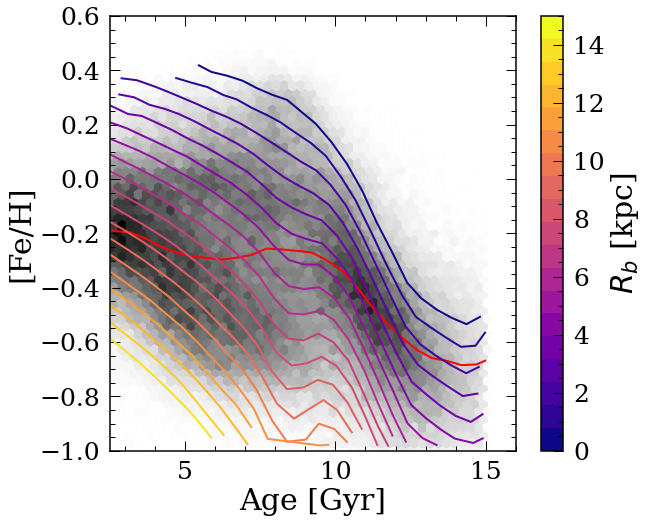

In [1663]:
Rbbin = np.linspace(0,15,20)
color_amr = getcolor(range(len(Rbbin)))

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hexbin(sub_tryRb['AGE'], sub_tryRb['FEH'], cmap='binary',
          extent=(2.5,16,-1,0.6), gridsize=50, mincnt=1)

sub_tryRb = sub_tryRb.sort_values(by='AGE')
age_rbnow, feh_rbnow = movingMed_time(sub_tryRb['AGE'], sub_tryRb['FEH'],
                                     1,0.5)
plt.plot(age_rbnow, feh_rbnow, 'r-')

for i in trange(len(Rbbin)-1):
    m = (sub_tryRb['Rb']>Rbbin[i])&(sub_tryRb['Rb']<Rbbin[i+1])
    age_amr_all, feh_amr_all = sub_tryRb['AGE'].values[m], sub_tryRb['FEH'].values[m]
    age_amr_all, feh_amr_all = zip(*sorted(zip(age_amr_all, feh_amr_all)))
    age_amr_all, feh_amr_all = np.array(age_amr_all), np.array(feh_amr_all)
    age_amr, feh_amr = movingMed_time(age_amr_all, feh_amr_all,
                                     1,0.5)
    plt.plot(age_amr, feh_amr, '-', color=color_amr[i], linewidth=2)
    plt.xlim([2.5,16])
    plt.ylim([-1,0.6])
plt.scatter(-100,-100, c=0, vmin=min(Rbbin), vmax=max(Rbbin), 
            cmap=plt.get_cmap('plasma', len(Rbbin)-1))
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')
cb = plt.colorbar()
cb.set_label('$R_b$ [kpc]')

In [1196]:
"""agebin = np.linspace(2,15,14)
meanfeh = np.zeros(len(agebin)-1)
meanafe = np.zeros(len(agebin)-1)

allext = [-2.5,0.5,-0.05,0.3]

fig, axarr = plt.subplots(2,3,gridspec_kw={'hspace': 0, 'wspace': 0},
                          figsize=(30,20))

sub_tryRb_sn = sub_tryRb_sn.dropna(subset=['R','FEH','ALPHA_FE','AGE','Rb'])
sub_tryRb_sn = sub_tryRb.loc[abs(sub_tryRb['R']-8.2)<3].reset_index(drop=True)
sub_tryRb_sn_old = sub_rbir.loc[abs(sub_rbir['R']-8.2)<3].reset_index(drop=True)

axarr[0,0].hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(allext[0], allext[1], allext[2], allext[3]), gridsize=50, 
                  mincnt=1, vmin=1, vmax=500)
for i in range(len(agebin)-1):
    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb']-8.2)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

axarr[0,0].plot(meanfeh, meanafe, 'r--', linewidth=4, label='After Correction')
axarr[0,0].scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=500, edgecolor='w', zorder=10)
axarr[0,0].set_title('7.7 kpc < $R_b$ < 8.7 kpc', fontsize=30)
# plot old Rb
for i in range(len(agebin)-1):
    m = (sub_tryRb_sn_old['AGE']>agebin[i])&(sub_tryRb_sn_old['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn_old['Rb']-8.2)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn_old['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn_old['ALPHA_FE'].values[m]).dropna())
axarr[0,0].plot(meanfeh, meanafe, 'k--', linewidth=4, label='Before Correction')        
axarr[0,0].legend()





axarr[0,1].hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(allext[0], allext[1], allext[2], allext[3]), gridsize=50, 
                  mincnt=1, vmin=1, vmax=500)
for i in range(len(agebin)-1):
    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb'])>10)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())
axarr[0,1].plot(meanfeh, meanafe, 'r--', linewidth=4)
axarr[0,1].scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
           s=500, edgecolor='w', zorder=10)
axarr[0,1].set_title('$R_b$ > 10 kpc', fontsize=30)
for i in range(len(agebin)-1):
    m = (sub_tryRb_sn_old['AGE']>agebin[i])&(sub_tryRb_sn_old['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn_old['Rb'])>10)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn_old['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn_old['ALPHA_FE'].values[m]).dropna())
axarr[0,1].plot(meanfeh, meanafe, 'k--', linewidth=4, label='Before Correction')        


axarr[0,2].hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(allext[0], allext[1], allext[2], allext[3]), gridsize=50, 
                  mincnt=1, vmin=1, vmax=500)
for i in range(len(agebin)-1):
    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb'])<5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())
axarr[0,2].plot(meanfeh, meanafe, 'r--', linewidth=4)
axarr[0,2].scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=500, edgecolor='w', zorder=10)
axarr[0,2].set_title('$R_b$ < 5 kpc', fontsize=30)
for i in range(len(agebin)-1):
    m = (sub_tryRb_sn_old['AGE']>agebin[i])&(sub_tryRb_sn_old['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn_old['Rb'])<5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn_old['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn_old['ALPHA_FE'].values[m]).dropna())
axarr[0,2].plot(meanfeh, meanafe, 'k--', linewidth=4, label='Before Correction')        








sub_tryRb_sn = sub_tryRb.loc[abs(sub_tryRb['R']-10)<0.5].reset_index(drop=True)
sub_tryRb_sn_old = sub_rbir.loc[abs(sub_rbir['R']-10)<0.5].reset_index(drop=True)


axarr[1,0].hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(allext[0], allext[1], allext[2], allext[3]), gridsize=50, 
                  mincnt=1, vmin=1, vmax=500)
for i in range(len(agebin)-1):
    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb']-8.2)<0.5)
    if sum(m)<5:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())
axarr[1,0].plot(meanfeh, meanafe, 'r--', linewidth=4)
im = axarr[1,0].scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
           s=500, edgecolor='w', zorder=10)
for i in range(len(agebin)-1):
    m = (sub_tryRb_sn_old['AGE']>agebin[i])&(sub_tryRb_sn_old['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn_old['Rb']-8.2)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn_old['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn_old['ALPHA_FE'].values[m]).dropna())
axarr[1,0].plot(meanfeh, meanafe, 'k--', linewidth=4)        




axarr[1,1].hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(allext[0], allext[1], allext[2], allext[3]), gridsize=50, 
                  mincnt=1, vmin=1, vmax=500)
for i in range(len(agebin)-1):
    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb'])>10)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())
axarr[1,1].plot(meanfeh, meanafe, 'r--', linewidth=4)
axarr[1,1].scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=500, edgecolor='w', zorder=10)
for i in range(len(agebin)-1):
    m = (sub_tryRb_sn_old['AGE']>agebin[i])&(sub_tryRb_sn_old['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn_old['Rb'])>10)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn_old['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn_old['ALPHA_FE'].values[m]).dropna())
axarr[1,1].plot(meanfeh, meanafe, 'k--', linewidth=4)    


axarr[1,2].hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(allext[0], allext[1], allext[2], allext[3]), gridsize=50, 
                  mincnt=1, vmin=1, vmax=500)
for i in range(len(agebin)-1):
    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb'])<5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())
axarr[1,2].plot(meanfeh, meanafe, 'r--', linewidth=4)
axarr[1,2].scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=500, edgecolor='w', zorder=10)
for i in range(len(agebin)-1):
    m = (sub_tryRb_sn_old['AGE']>agebin[i])&(sub_tryRb_sn_old['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn_old['Rb'])<5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn_old['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn_old['ALPHA_FE'].values[m]).dropna())
axarr[1,2].plot(meanfeh, meanafe, 'k--', linewidth=4)   


axarr[0,0].set_xticks([])
axarr[0,1].set_xticks([])
axarr[0,2].set_xticks([])
axarr[1,1].set_xticks([])
axarr[1,2].set_xticks([])

axarr[0,0].set_yticks([])
axarr[0,1].set_yticks([])
axarr[0,2].set_yticks([])
axarr[1,1].set_yticks([])
axarr[1,2].set_yticks([])


axarr[0,0].set_xlim([allext[0], allext[1]])
axarr[0,1].set_xlim([allext[0], allext[1]])
axarr[0,2].set_xlim([allext[0], allext[1]])
axarr[1,0].set_xlim([allext[0], allext[1]])
axarr[1,1].set_xlim([allext[0], allext[1]])
axarr[1,2].set_xlim([allext[0], allext[1]])

axarr[0,0].set_ylim([allext[2], allext[3]])
axarr[0,1].set_ylim([allext[2], allext[3]])
axarr[0,2].set_ylim([allext[2], allext[3]])
axarr[1,0].set_ylim([allext[2], allext[3]])
axarr[1,1].set_ylim([allext[2], allext[3]])
axarr[1,2].set_ylim([allext[2], allext[3]])

fig.text(0.45, 0.08, '[Fe/H]', fontsize=40)
fig.text(0.03, 0.45, '[α/Fe]', fontsize=40, rotation='vertical')

fig.text(0.07, 0.2, '9.5 kpc < R < 10.5 kpc', fontsize=30, rotation='vertical')
fig.text(0.07, 0.6, '7.7 kpc < R < 8.7 kpc', fontsize=30, rotation='vertical')


cb_ax = fig.add_axes([0.91, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax,orientation = 'vertical')
car = cbar.set_label('Age [Gyr]',fontsize = 50,labelpad = 5)

#plt.savefig('Figures/eps/timeevol',bbox_inches='tight')
#plt.savefig('Figures/timeevol.png',bbox_inches='tight')"""

"agebin = np.linspace(2,15,14)\nmeanfeh = np.zeros(len(agebin)-1)\nmeanafe = np.zeros(len(agebin)-1)\n\nallext = [-2.5,0.5,-0.05,0.3]\n\nfig, axarr = plt.subplots(2,3,gridspec_kw={'hspace': 0, 'wspace': 0},\n                          figsize=(30,20))\n\nsub_tryRb_sn = sub_tryRb_sn.dropna(subset=['R','FEH','ALPHA_FE','AGE','Rb'])\nsub_tryRb_sn = sub_tryRb.loc[abs(sub_tryRb['R']-8.2)<3].reset_index(drop=True)\nsub_tryRb_sn_old = sub_rbir.loc[abs(sub_rbir['R']-8.2)<3].reset_index(drop=True)\n\naxarr[0,0].hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',\n          extent=(allext[0], allext[1], allext[2], allext[3]), gridsize=50, \n                  mincnt=1, vmin=1, vmax=500)\nfor i in range(len(agebin)-1):\n    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])\n    m = m&(abs(sub_tryRb_sn['Rb']-8.2)<0.5)\n    if sum(m)<10:\n        meanfeh[i] = np.nan\n        meanafe[i] = np.nan\n    else:\n        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH

array([[<AxesSubplot:title={'center':'VZ'}>,
        <AxesSubplot:title={'center':'VT'}>],
       [<AxesSubplot:title={'center':'VR'}>,
        <AxesSubplot:title={'center':'ECC'}>]], dtype=object)

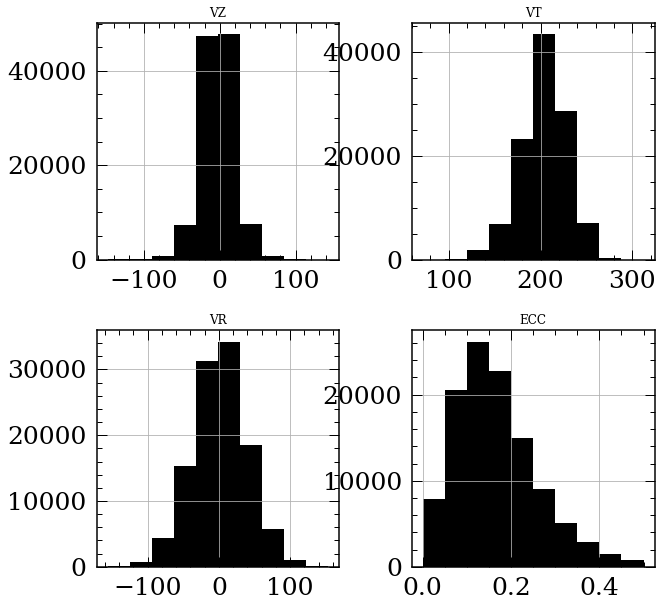

In [1664]:
sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['Z'])<0.5].reset_index(drop=True)
sub_tryRb = sub_tryRb.loc[sub_tryRb['FEH']>-1].reset_index(drop=True)
sub_tryRb = sub_tryRb.dropna(subset=['Rb','AGE','ALPHA_FE','VZ',
                                    'VT','VR'])

sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['VZ'])<200]
sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['VT'])<500]
sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['VR'])<500]
sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['ECC'])<0.5]

sub_tryRb[['VZ','VT','VR','ECC']].hist(color='k')

In [1665]:
ages, rs, avrs_z = avr( sub_tryRb['Rb'].values, sub_tryRb['AGE'].values,
                       sub_tryRb['VZ'].values, 
                     rbin=np.linspace(2,15,10), agebin=np.linspace(2,20,15))

ages, rs, avrs_phi = avr(sub_tryRb['Rb'].values, sub_tryRb['AGE'].values,
                         sub_tryRb['VT'].values, 
                     rbin=np.linspace(2,15,10), agebin=np.linspace(2,20,15))

ages, rs, avrs_r = avr(sub_tryRb['Rb'].values, sub_tryRb['AGE'].values,
                       sub_tryRb['VR'].values, 
                     rbin=np.linspace(2,15,10), agebin=np.linspace(2,20,15))



def vphisvphi(age, r, vz, rbin=np.linspace(6,12,4), agebin=np.linspace(0,14,10)):
    colors = getcolor(range(len(rbin)+1))
    avrs = np.zeros((len(rbin)-1, len(agebin)-1))
    for i in range(len(rbin)-1):
        m = (r>rbin[i])&(r<rbin[i+1])
        age_r, r_r, vz_r = age[m], r[m], vz[m]
        for j in range(len(agebin)-1):
            m2 = (age_r>agebin[j])&(age_r<agebin[j+1])
            if sum(m2)<50:
                avrs[i,j]=np.nan
            else:
                vz_r_age = vz_r[m2]
                avrs[i,j] = 1.5*sum(abs(vz_r_age-np.median(vz_r_age)))/sum(m2)
                avrs[i,j] = np.median(vz_r_age)/avrs[i,j]
    return (agebin[:-1]+agebin[1:])/2, (rbin[:-1]+rbin[1:])/2, avrs

"""ages, rs, avrs_phivphi = vphisvphi(sub_tryRb['Rb'].values, sub_tryRb['AGE'].values,
                         sub_tryRb['VT'].values, 
                     rbin=np.linspace(2,15,10), agebin=np.linspace(2,20,15))"""

"ages, rs, avrs_phivphi = vphisvphi(sub_tryRb['Rb'].values, sub_tryRb['AGE'].values,\n                         sub_tryRb['VT'].values, \n                     rbin=np.linspace(2,15,10), agebin=np.linspace(2,20,15))"

In [1666]:

np.save('vd_agebin',np.array((ages, rs, avrs_z, avrs_phi, avrs_r)))


<ipython-input-1666-1e4936b31b79>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('vd_agebin',np.array((ages, rs, avrs_z, avrs_phi, avrs_r)))


"plt.figure(figsize=(10,8))\nfor i in range(len(rs)):\n    plt.plot(ages, avrs_phivphi[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],\n            markersize=15)\n    plt.xlabel('Rb [kpc]')\n    plt.ylabel('$σ_ϕ$ [km/s]')\nplt.ylim([0, 15])\nplt.xlim([0,20])\nplt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap='plasma')\ncb = plt.colorbar()\ncb.set_label('Age [Gyr]')"

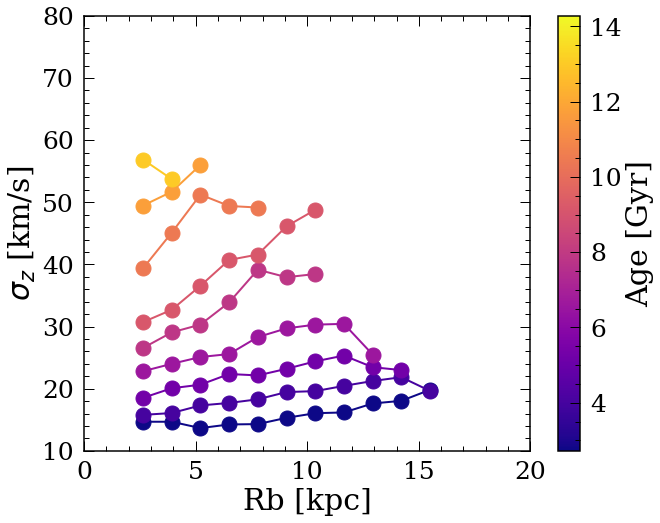

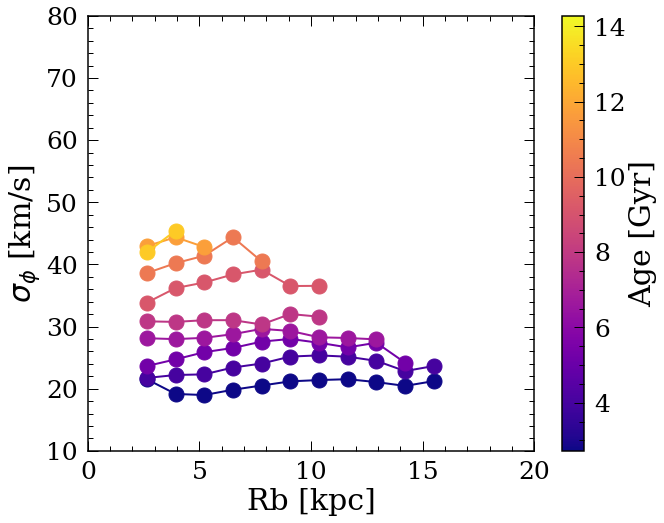

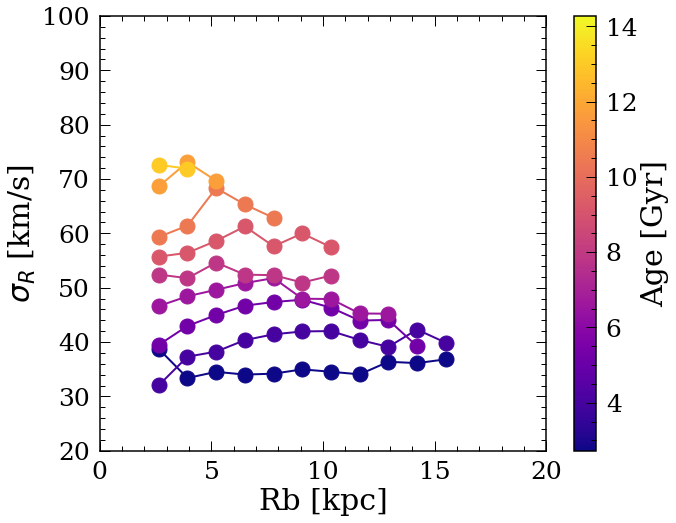

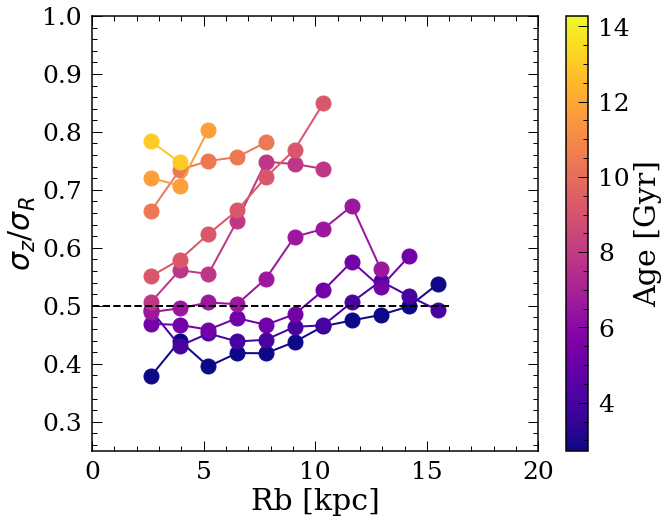

In [1667]:




colors = getcolor(np.linspace(2,15,10))

plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('Rb [kpc]')
    plt.ylabel('$σ_z$ [km/s]')
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap='plasma')
plt.ylim([10, 80])
plt.xlim([0,20])
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()



plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, avrs_phi[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('Rb [kpc]')
    plt.ylabel('$σ_ϕ$ [km/s]')
plt.ylim([10, 80])
plt.xlim([0,20])
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()



plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, avrs_r[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('Rb [kpc]')
    plt.ylabel('$σ_R$ [km/s]')
plt.ylim([20, 100])
plt.xlim([0,20])
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()



plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:]/avrs_r[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('Rb [kpc]')
    plt.ylabel('$σ_z$/$σ_R$')
plt.ylim([0.25, 1])
plt.xlim([0,20])
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()

plt.plot([0,16], [0.5,0.5], 'k--')


"""plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, avrs_phivphi[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('Rb [kpc]')
    plt.ylabel('$σ_ϕ$ [km/s]')
plt.ylim([0, 15])
plt.xlim([0,20])
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')"""

In [1668]:
#sub['Rmean'] = (sub['R_PERI']+sub['R_APO'])/2

#sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['Z'])<1].reset_index(drop=True)
ages, rs, avrs_z = avr(sub_tryRb['AGE'].values, sub_tryRb['Rb'].values, 
                       sub_tryRb['VZ'].values, 
                     rbin=np.linspace(2,15,5), agebin=np.linspace(0,15,16))

ages, rs, avrs_phi = avr(sub_tryRb['AGE'].values, sub_tryRb['Rb'].values, 
                         sub_tryRb['VT'].values, 
                     rbin=np.linspace(2,15,5), agebin=np.linspace(0,15,16))

ages, rs, avrs_r = avr(sub_tryRb['AGE'].values, sub_tryRb['Rb'].values, 
                       sub_tryRb['VR'].values, 
                     rbin=np.linspace(2,15,5), agebin=np.linspace(0,15,16))



np.save('vd_Rbin',np.array((ages, rs, avrs_z, avrs_phi, avrs_r)))

<ipython-input-1668-721476f7901c>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('vd_Rbin',np.array((ages, rs, avrs_z, avrs_phi, avrs_r)))


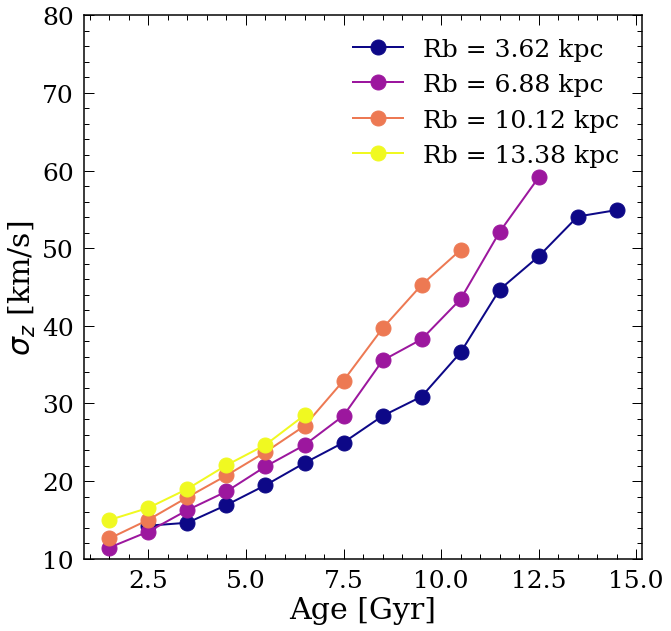

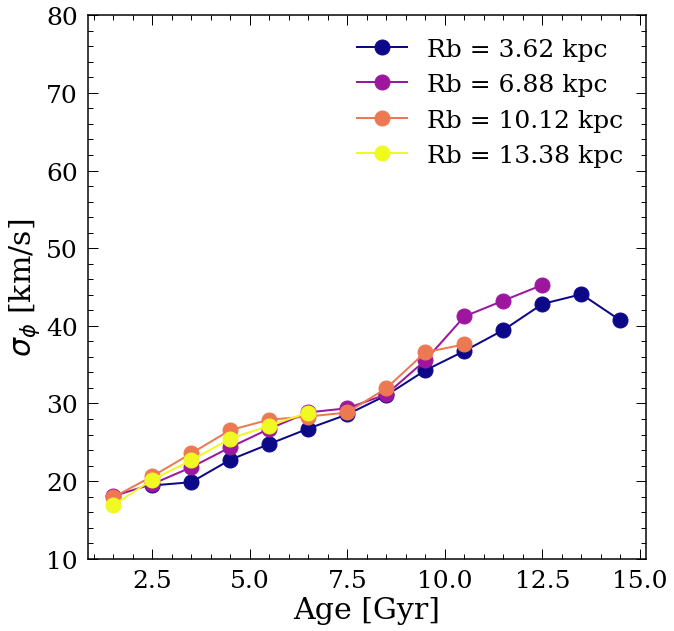

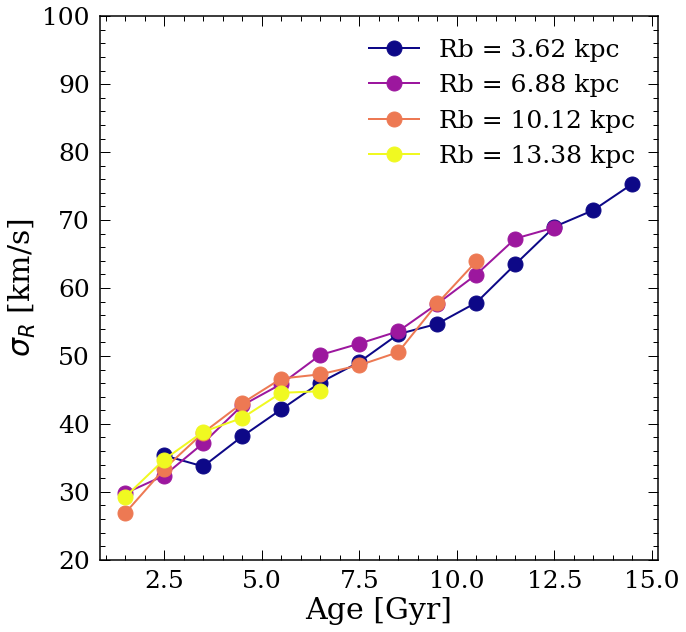

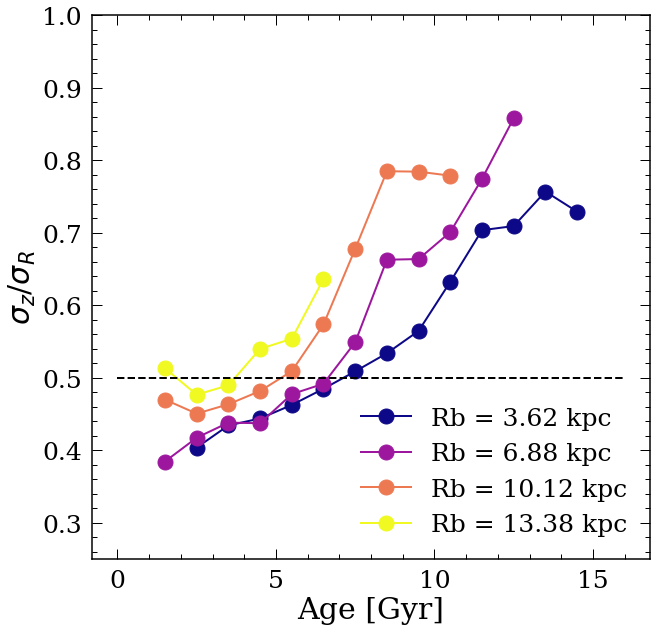

In [1669]:

colors = getcolor(rs)

plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:], 'o-', color=colors[i], label='Rb = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_z$ [km/s]')
plt.ylim([10, 80])
plt.legend()



plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_phi[i,:], 'o-', color=colors[i], label='Rb = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_ϕ$ [km/s]')
plt.ylim([10, 80])
plt.legend()



plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_r[i,:], 'o-', color=colors[i], label='Rb = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_R$ [km/s]')
plt.ylim([20, 100])
plt.legend()



plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:]/avrs_r[i,:], 'o-', color=colors[i], label='Rb = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_z$/$σ_R$')
plt.legend()
plt.ylim([0.25, 1])

plt.plot([0,16], [0.5,0.5], 'k--')





In [1670]:
def getmigration(r, rbir, age, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5]):
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    r, rbir, age = r[m], rbir[m], age[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, rbir_sing = r[m], rbir[m]

        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                scatters[i,j] = np.nan
            else:
                r_sing_2, rbir_sing_2 = r_sing[m], rbir_sing[m]
                scatters[i,j] = np.std(rbir_sing_2-r_sing_2)

                
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters




(0.0, 7.0)

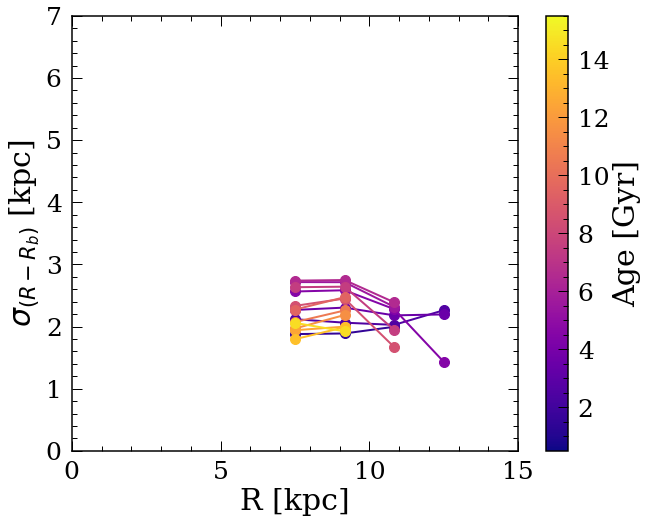

In [1671]:
#agebincalc = np.linspace(0,16,17)
m = (abs(sub_tryRb['Z'])<0.5)
m = (abs(sub_tryRb['Z'])<1)&(sub_tryRb['AGE_ERR']<np.diff(agebincalc)[0])
m = m&(sub_tryRb['AGE']>1.5)

ages, rs, sigmaR = getmigration(sub_tryRb['R'].values[m], 
                                        sub_tryRb['Rb_new'].values[m], 
                                        sub_tryRb['AGE'].values[m],
                                        agebin=agebincalc,
                                        xlims=[0,15],rbin=10)



colors = getcolor(ages)
plt.figure(figsize=(10,8))
for i in range(len(ages)):
    plt.plot(rs, sigmaR[i,:], '-o', color=colors[i], markersize=10)
plt.scatter(-10,-10,c=0, vmin=min(ages), vmax=max(ages),cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.xlabel('R [kpc]')
plt.ylabel('$σ_{(R-R_b)}$ [kpc]')
plt.xlim([0,15])
plt.ylim([0,7])






In [1672]:
def movingMed_time(x,y,x_window,delta_x_window):
    # medians output
    x_med=np.zeros(len(x))
    y_med=np.zeros(len(y))

    # define the boundaries of the windows
    if len(x)==0:
        return x_med,y_med
    window_min=float(min(x))
    window_max=float(window_min+delta_x_window)
    
    # max time
    maxtime=max(x)
    
    # break when time window hits the end
    while window_max<=maxtime+x_window:
        seldf=(x>=window_min) & (x<=window_max) # get points between the window
        if sum(seldf)<10:
            x_med[seldf]=np.nan
            y_med[seldf]=np.nan
        else:
            x_med[seldf]=np.median(x[seldf]) # all values for these indices are subsituded with median time
            y_med[seldf]=np.median(y[seldf]) # all values for these indices are subsituded with median flux

        # slide the window
        window_min=window_min+delta_x_window
        window_max=window_max+delta_x_window
    return x_med, y_med

"plt.figure(figsize=(10,8))\nplt.hexbin(sub_tryRb['FEH'], sub_tryRb['ALPHA_FE'], cmap='binary',\n          extent=(-1.3,0.6,-0.2,0.4), gridsize=50, mincnt=1)\nfor i in range(len(Rbbin)-1):\n\n    m = (sub_tryRb['Rb_new']>Rbbin[i])&(sub_tryRb['Rb_new']<Rbbin[i+1])\n\n    age_amr_all, feh_amr_all = sub_tryRb['ALPHA_FE'].values[m], sub_tryRb['FEH'].values[m]\n    age_amr_all, feh_amr_all = zip(*sorted(zip(age_amr_all, feh_amr_all)))\n    age_amr_all, feh_amr_all = np.array(age_amr_all), np.array(feh_amr_all)\n    \n    age_amr, feh_amr = movingMed_time(age_amr_all, feh_amr_all,\n                                     0.04,0.04)\n    plt.plot(feh_amr, age_amr, '-o', color=color_amr[i], linewidth=2)\n    plt.xlim([-1.3,0.6])\n    plt.ylim([-0.2,0.4])\n    #print(sum(m))\n    #plt.title('%.2f kpc < Rb < %.2f kpc'%(Rbbin[i], Rbbin[i+1]), fontsize=25)\nplt.scatter(-100,-100, c=0, vmin=min(Rbbin), vmax=max(Rbbin), \n            cmap=plt.get_cmap('plasma', len(Rbbin)-1))\nplt.xlabel('[Fe/H]')\nplt

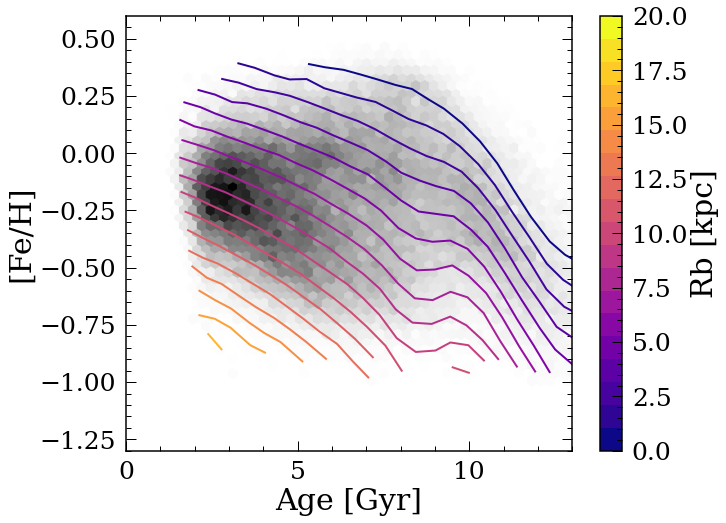

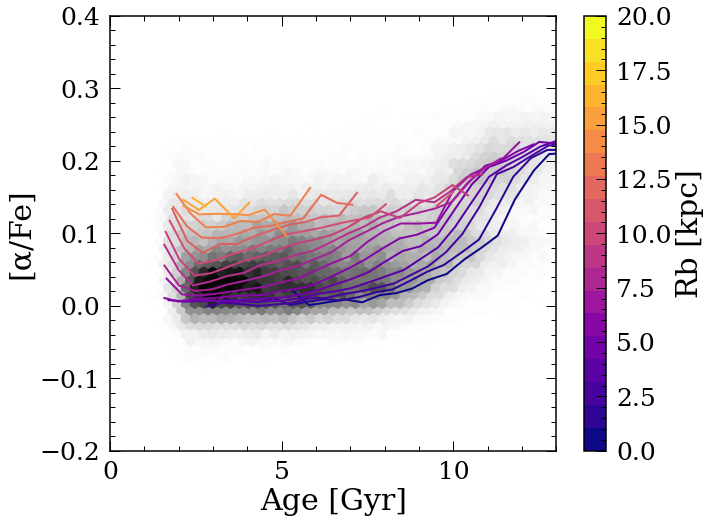

In [1673]:
Rbbin = np.linspace(0,20,20)
color_amr = getcolor(range(len(Rbbin)))

plt.figure(figsize=(10,8))
plt.hexbin(sub_tryRb['AGE'], sub_tryRb['FEH'], cmap='binary',
          extent=(0,13,-1.3,0.6), gridsize=50, mincnt=1)
for i in range(len(Rbbin)-1):

    m = (sub_tryRb['Rb_new']>Rbbin[i])&(sub_tryRb['Rb_new']<Rbbin[i+1])
    """plt.hexbin(sub['AGE'][m], sub['FEH'][m], extent=(0,18,-2.5,0.5), cmap='jet',
            mincnt=1, gridsize=50)"""
    age_amr_all, feh_amr_all = sub_tryRb['AGE'].values[m], sub_tryRb['FEH'].values[m]
    age_amr_all, feh_amr_all = zip(*sorted(zip(age_amr_all, feh_amr_all)))
    age_amr_all, feh_amr_all = np.array(age_amr_all), np.array(feh_amr_all)
    age_amr, feh_amr = movingMed_time(age_amr_all, feh_amr_all,
                                     1,0.5)
    plt.plot(age_amr, feh_amr, '-', color=color_amr[i], linewidth=2)
    plt.xlim([0,13])
    plt.ylim([-1.3,0.6])
    #print(sum(m))
    #plt.title('%.2f kpc < Rb < %.2f kpc'%(Rbbin[i], Rbbin[i+1]), fontsize=25)
plt.scatter(-100,-100, c=0, vmin=min(Rbbin), vmax=max(Rbbin), 
            cmap=plt.get_cmap('plasma', len(Rbbin)-1))
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')
cb = plt.colorbar()
cb.set_label('Rb [kpc]')
    

plt.figure(figsize=(10,8))
plt.hexbin(sub_tryRb['AGE'], sub_tryRb['ALPHA_FE'], cmap='binary',
          extent=(0,13,-0.2,0.4), gridsize=50, mincnt=1)
for i in range(len(Rbbin)-1):

    m = (sub_tryRb['Rb_new']>Rbbin[i])&(sub_tryRb['Rb_new']<Rbbin[i+1])
    """plt.hexbin(sub['AGE'][m], sub['FEH'][m], extent=(0,18,-2.5,0.5), cmap='jet',
            mincnt=1, gridsize=50)"""
    age_amr_all, feh_amr_all = sub_tryRb['AGE'].values[m], sub_tryRb['ALPHA_FE'].values[m]
    age_amr_all, feh_amr_all = zip(*sorted(zip(age_amr_all, feh_amr_all)))
    age_amr_all, feh_amr_all = np.array(age_amr_all), np.array(feh_amr_all)
    age_amr, feh_amr = movingMed_time(age_amr_all, feh_amr_all,
                                     1,0.5)
    plt.plot(age_amr, feh_amr, '-', color=color_amr[i], linewidth=2)
    plt.xlim([0,13])
    plt.ylim([-0.2,0.4])
    #print(sum(m))
    #plt.title('%.2f kpc < Rb < %.2f kpc'%(Rbbin[i], Rbbin[i+1]), fontsize=25)
plt.scatter(-100,-100, c=0, vmin=min(Rbbin), vmax=max(Rbbin), 
            cmap=plt.get_cmap('plasma', len(Rbbin)-1))
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Rb [kpc]')


"""plt.figure(figsize=(10,8))
plt.hexbin(sub_tryRb['FEH'], sub_tryRb['ALPHA_FE'], cmap='binary',
          extent=(-1.3,0.6,-0.2,0.4), gridsize=50, mincnt=1)
for i in range(len(Rbbin)-1):

    m = (sub_tryRb['Rb_new']>Rbbin[i])&(sub_tryRb['Rb_new']<Rbbin[i+1])

    age_amr_all, feh_amr_all = sub_tryRb['ALPHA_FE'].values[m], sub_tryRb['FEH'].values[m]
    age_amr_all, feh_amr_all = zip(*sorted(zip(age_amr_all, feh_amr_all)))
    age_amr_all, feh_amr_all = np.array(age_amr_all), np.array(feh_amr_all)
    
    age_amr, feh_amr = movingMed_time(age_amr_all, feh_amr_all,
                                     0.04,0.04)
    plt.plot(feh_amr, age_amr, '-o', color=color_amr[i], linewidth=2)
    plt.xlim([-1.3,0.6])
    plt.ylim([-0.2,0.4])
    #print(sum(m))
    #plt.title('%.2f kpc < Rb < %.2f kpc'%(Rbbin[i], Rbbin[i+1]), fontsize=25)
plt.scatter(-100,-100, c=0, vmin=min(Rbbin), vmax=max(Rbbin), 
            cmap=plt.get_cmap('plasma', len(Rbbin)-1))
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Rb [kpc]')"""
    
    



###  [$\alpha$/Fe] evolution for |R-8.2|<0.5

In [ ]:
# without correction
agebin = np.linspace(0,15,16)

meanfeh = np.zeros(len(agebin)-1)
meanafe = np.zeros(len(agebin)-1)

sub_tryRb_sn = sub_rbir.loc[abs(sub_rbir['R']-8.2)<0.5].reset_index(drop=True)

plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb']-8.2)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('7.7 kpc < Rb < 8.7 kpc', fontsize=25)



plt.subplot(1,3,2)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb']-12)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('11.5 kpc < Rb < 12.5 kpc', fontsize=25)



plt.subplot(1,3,3)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb']-3)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('2.5 kpc < Rb < 3.5 kpc', fontsize=25)
plt.tight_layout()

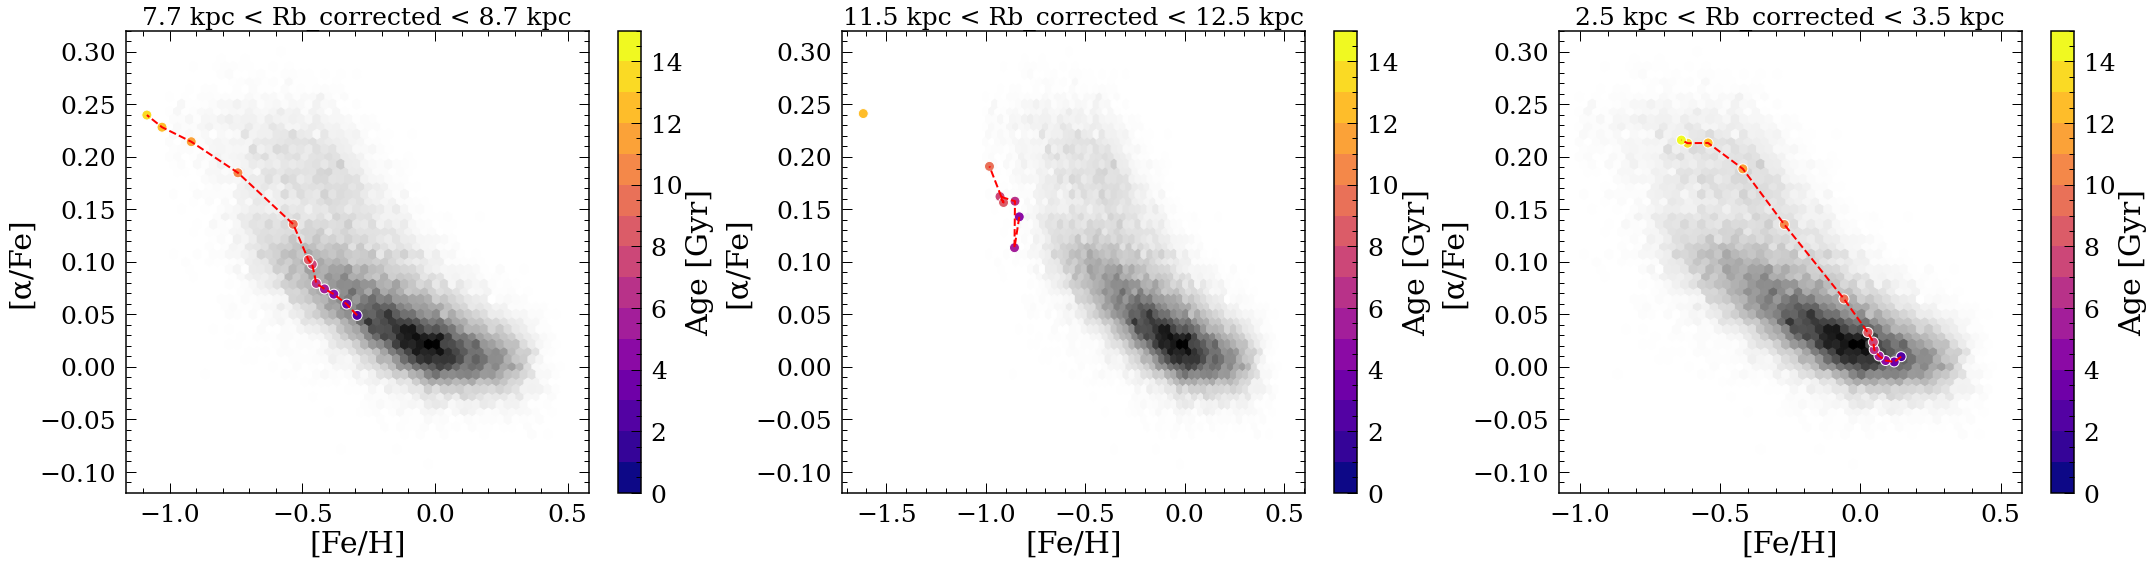

In [137]:
agebin = np.linspace(0,15,16)

meanfeh = np.zeros(len(agebin)-1)
meanafe = np.zeros(len(agebin)-1)

sub_tryRb_sn = sub_tryRb.loc[abs(sub_tryRb['R']-8.2)<0.5].reset_index(drop=True)

plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb_new']-8.2)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('7.7 kpc < Rb_corrected < 8.7 kpc', fontsize=25)



plt.subplot(1,3,2)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb_new'])>12)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('11.5 kpc < Rb_corrected < 12.5 kpc', fontsize=25)



plt.subplot(1,3,3)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb_new']-3)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('2.5 kpc < Rb_corrected < 3.5 kpc', fontsize=25)
plt.tight_layout()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

(-0.1, 0.3)

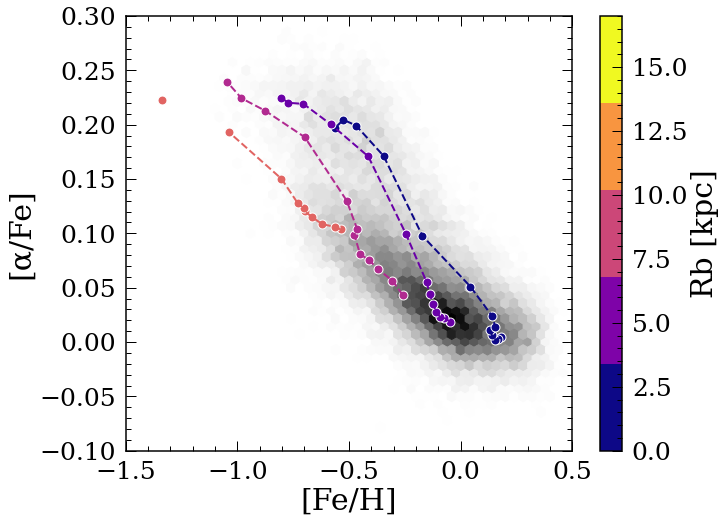

In [138]:
agebin = np.linspace(0,15,16)
Rbbin = np.linspace(0,17,6)

colors = getcolor(Rbbin)

sub_tryRb_sn = sub_tryRb.loc[abs(sub_tryRb['R']-8.2)<0.5].reset_index(drop=True)

plt.figure(figsize=(10,8))
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1.5,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for j in range(len(Rbbin)-1):
    meanfeh = np.zeros(len(agebin)-1)
    meanafe = np.zeros(len(agebin)-1)
    for i in range(len(agebin)-1):
        m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
        m = m&(sub_tryRb_sn['Rb_new']>Rbbin[j])
        m = m&(sub_tryRb_sn['Rb_new']<Rbbin[j+1])
        if sum(m)<10:
            meanfeh[i] = np.nan
            meanafe[i] = np.nan
        else:
            meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
            meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())
    plt.plot(meanfeh, meanafe, '--', color=colors[j])
    plt.scatter(meanfeh, meanafe, c = colors[j], 
                s=80, edgecolor='w',
                cmap=plt.get_cmap('plasma', len(Rbbin)-1),
               vmin=Rbbin[0], vmax=Rbbin[-1])

plt.scatter(-100, -100, c = 10, 
            s=80, cmap=plt.get_cmap('plasma', len(Rbbin)-1),
           vmin=Rbbin[0], vmax=Rbbin[-1])

plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Rb [kpc]')
plt.xlim([-1.5,0.5])
plt.ylim([-0.1,0.3])
#plt.title('7.7 kpc < Rb_corrected < 8.7 kpc', fontsize=25)

###  [$\alpha$/Fe] evolution for |R-10|<0.5

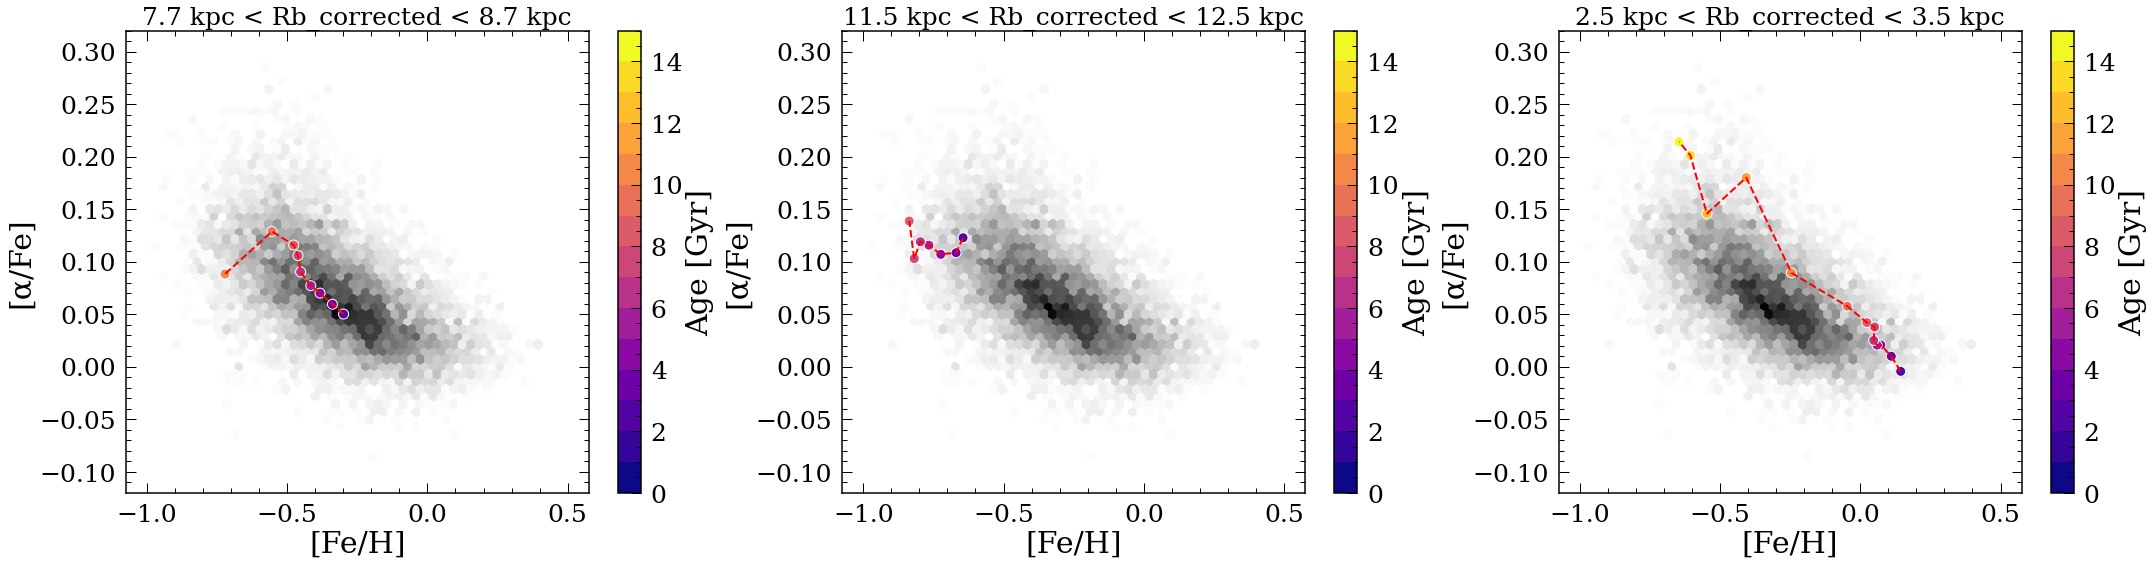

In [139]:
agebin = np.linspace(0,15,16)

meanfeh = np.zeros(len(agebin)-1)
meanafe = np.zeros(len(agebin)-1)

sub_tryRb_sn = sub_tryRb.loc[abs(sub_tryRb['R']-10)<0.5].reset_index(drop=True)

plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb_new']-8.2)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('7.7 kpc < Rb_corrected < 8.7 kpc', fontsize=25)



plt.subplot(1,3,2)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb_new']-12)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('11.5 kpc < Rb_corrected < 12.5 kpc', fontsize=25)



plt.subplot(1,3,3)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb_new']-3)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('2.5 kpc < Rb_corrected < 3.5 kpc', fontsize=25)
plt.tight_layout()

### Migration strength with age

In [140]:
from astropy import units as u
from astropy import uncertainty as unc

sub_tryRb['R_err'] = (sub_tryRb['PARALLAX'])**-2*(sub_tryRb['PARALLAX_ERROR'])


agebincalc_rm = np.linspace(0,14,15)
mean_dr = np.zeros(len(agebincalc_rm)-1)
mean_dr_err = np.zeros(len(agebincalc_rm)-1)

sub_tryRb['AGE_sca'] = sub_tryRb['AGE']/16*14
sub_tryRb = sub_tryRb.loc[sub_tryRb['AGE_ERR']<np.diff(agebincalc_rm)[0]]

for i in trange(len(agebincalc_rm)-1):
    sub_tryRb_sing = sub_tryRb.loc[(sub_tryRb['AGE_sca']>agebincalc_rm[i])&(sub_tryRb['AGE_sca']<agebincalc_rm[i+1])]
    #mean_dr[i] = np.std(sub_tryRb_sing['Rb_new']-sub_tryRb_sing['R'])    
    #mean_dr_err[i] = mean_dr[i]/(len(sub_tryRb_sing)-1)
    
    sub_tryRb_sing = sub_tryRb_sing.dropna(subset=['Rb_new','R_err','R'])
    sub_tryRb_sing = sub_tryRb_sing.loc[sub_tryRb_sing['R_err']<1]
    
    if len(sub_tryRb_sing)<30:
        mean_dr[i] = np.nan
        mean_dr_err[i] = np.nan
        continue
    Rbdist = unc.normal(sub_tryRb_sing['Rb_new'].values, 
                     std=sub_tryRb_sing['R_err'].values, 
                     n_samples=1000)
    Rdist = unc.normal(sub_tryRb_sing['R'].values, 
                     std=sub_tryRb_sing['R_err'].values, 
                     n_samples=1000)
    
    drdist = np.std(Rbdist-Rdist)
    
    mean_dr[i] = drdist.pdf_median()
    mean_dr_err[i] = np.median(np.sqrt(drdist.pdf_var()))

100%|██████████| 14/14 [00:07<00:00,  1.75it/s]


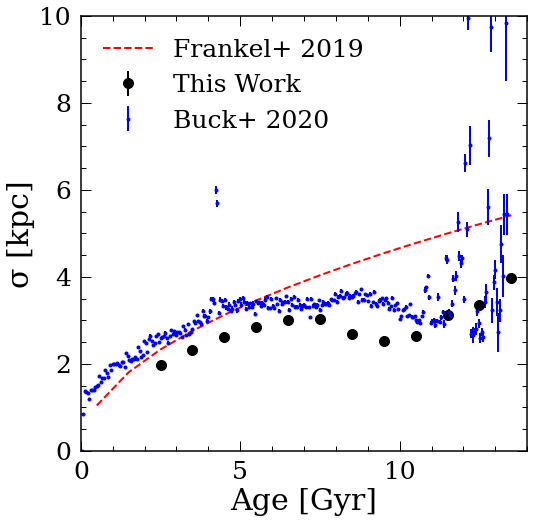

In [141]:
    
plt.figure(figsize=(8,8))
dR_sim = pd.read_pickle('BuckMigration.pkl')

plt.errorbar((agebincalc_rm[1:]+agebincalc_rm[:-1])/2, mean_dr,
             yerr=mean_dr_err, fmt='ko', label='This Work', 
            markersize=10)
plt.plot((agebincalc_rm[1:]+agebincalc_rm[:-1])/2, 
         3.9*np.sqrt((agebincalc_rm[1:]+agebincalc_rm[:-1])/2/7), 
         'r--', label='Frankel+ 2019')

m = (dR_sim['NoS']>30)
plt.errorbar(dR_sim['meanage'][m], dR_sim['meandR'][m],
             yerr=dR_sim['meadR_err'][m], fmt='bo', 
             label='Buck+ 2020', markersize=3)

plt.xlim([0,14])
plt.ylim([0,10])
plt.xlabel('Age [Gyr]')
plt.ylabel('σ [kpc]')
plt.legend()

# star forming region

In [1394]:
#sub_sel = pd.read_csv('Xiang_fitline.csv')
sub = Table.read('subgiant_fullparam_update.fits', format='fits')
sub = sub.to_pandas()
sub_sel = sub.loc[abs(sub['Z'])<0.5]

100%|██████████| 16/16 [00:00<00:00, 51.83it/s]


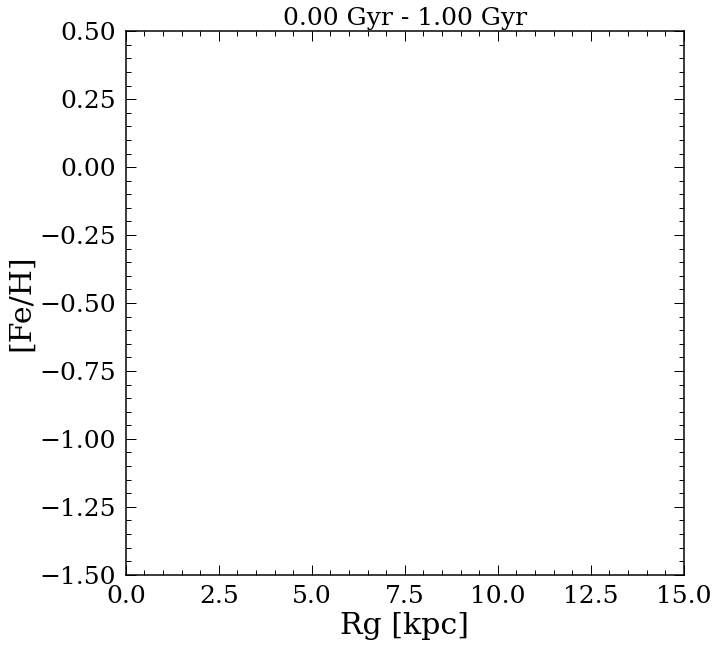

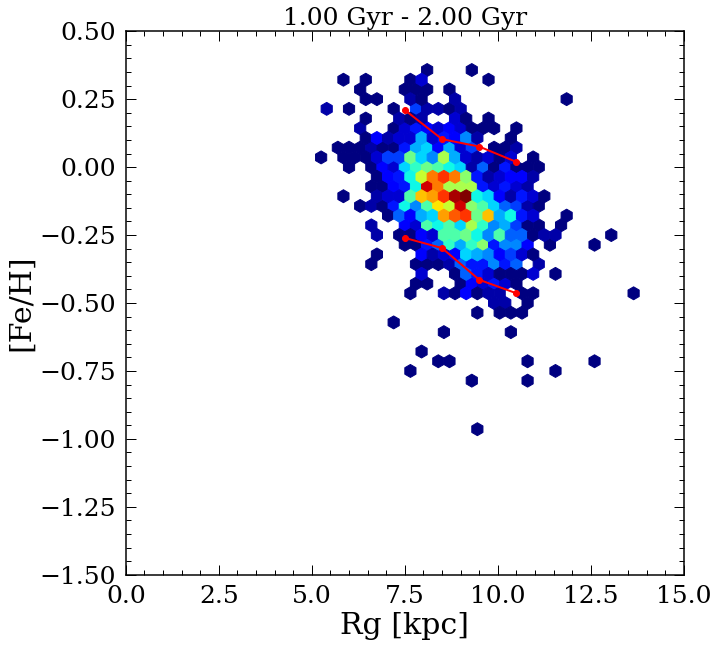

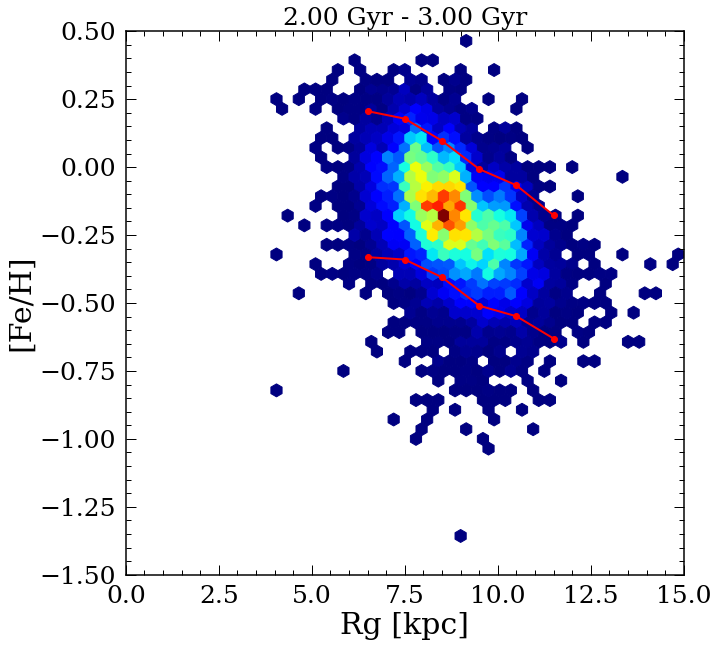

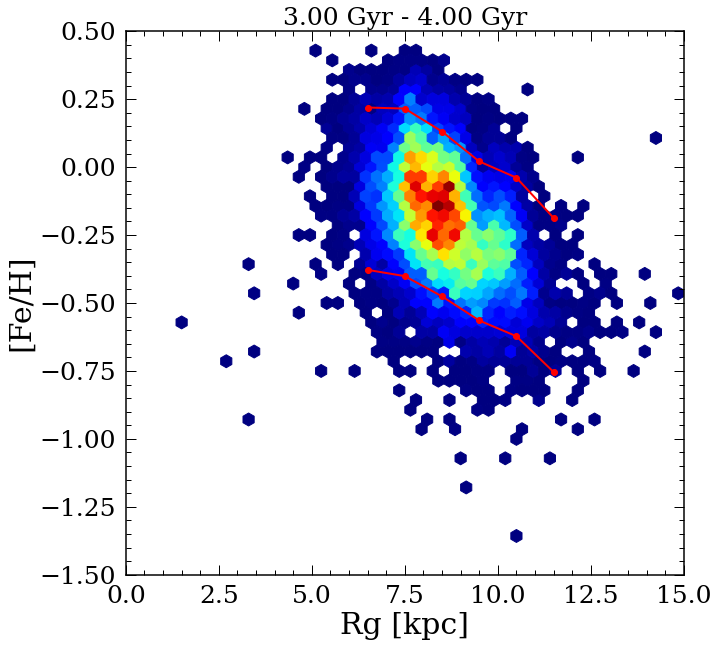

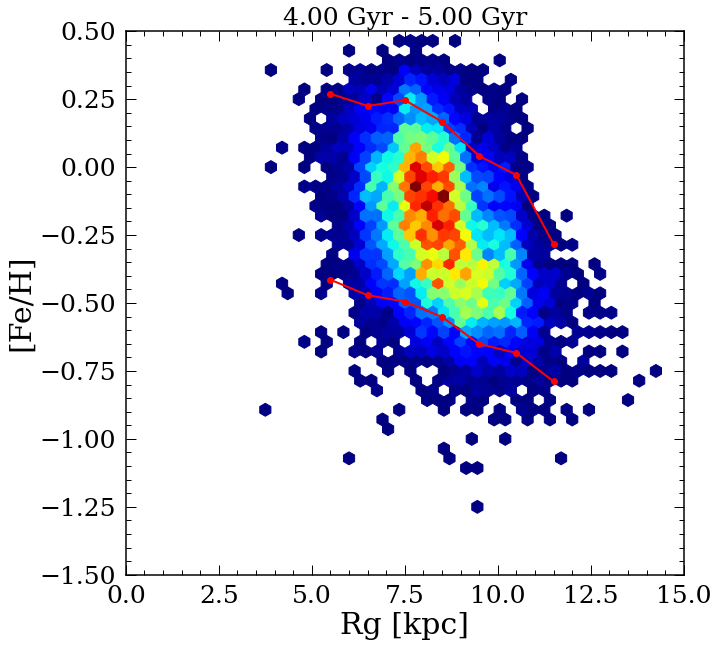

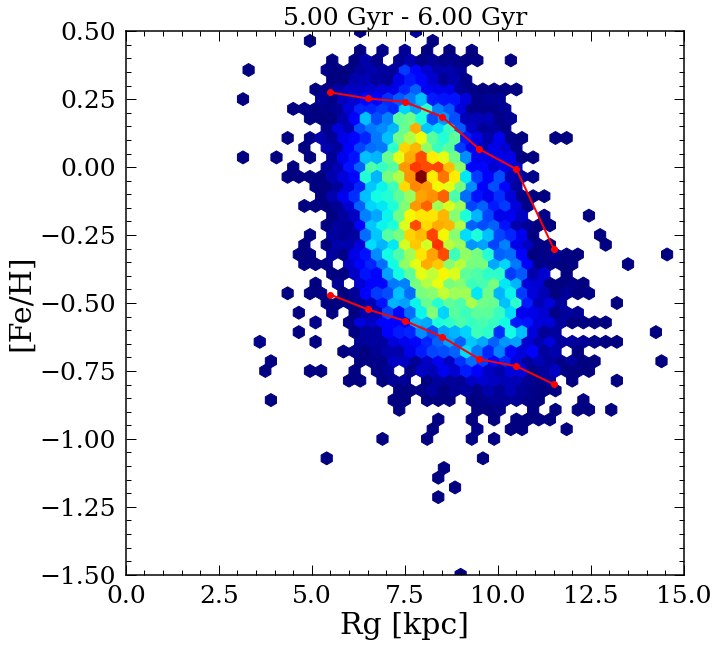

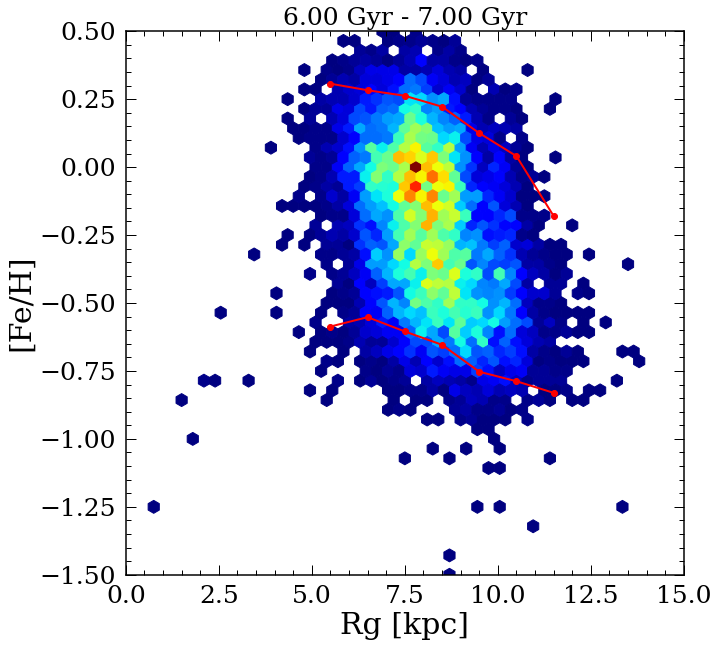

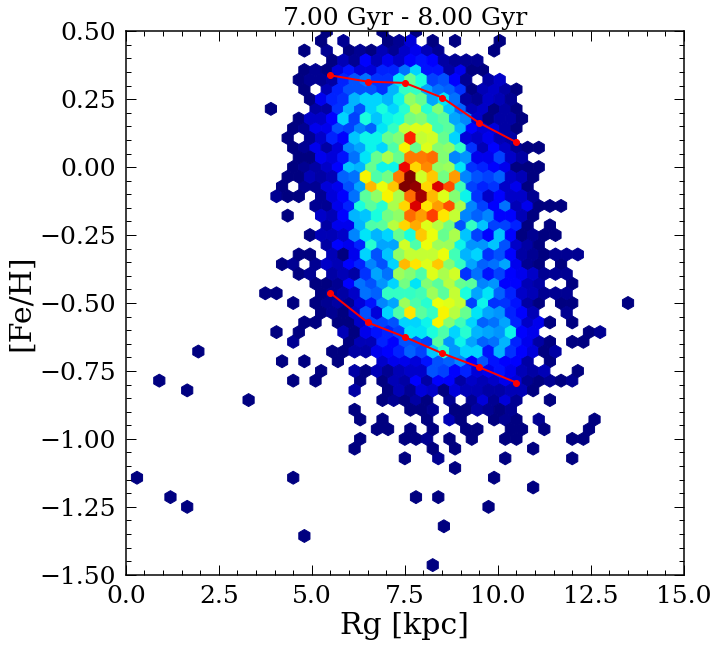

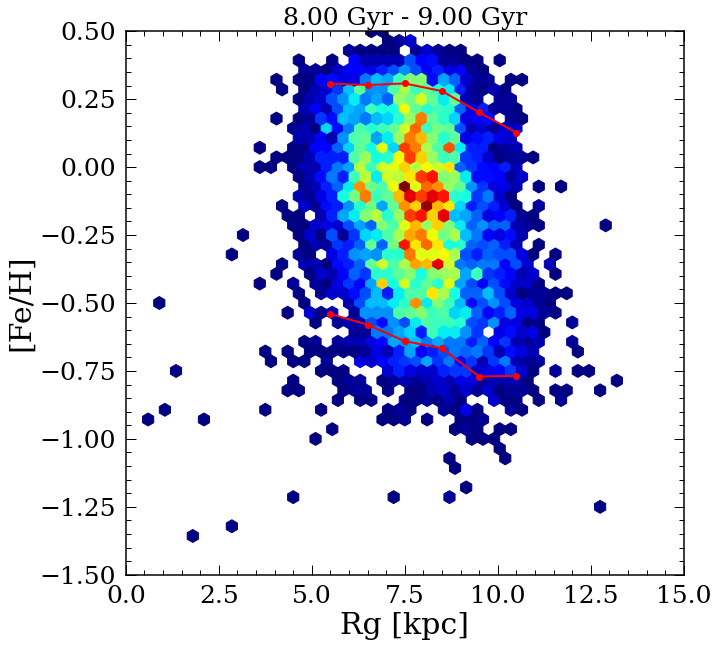

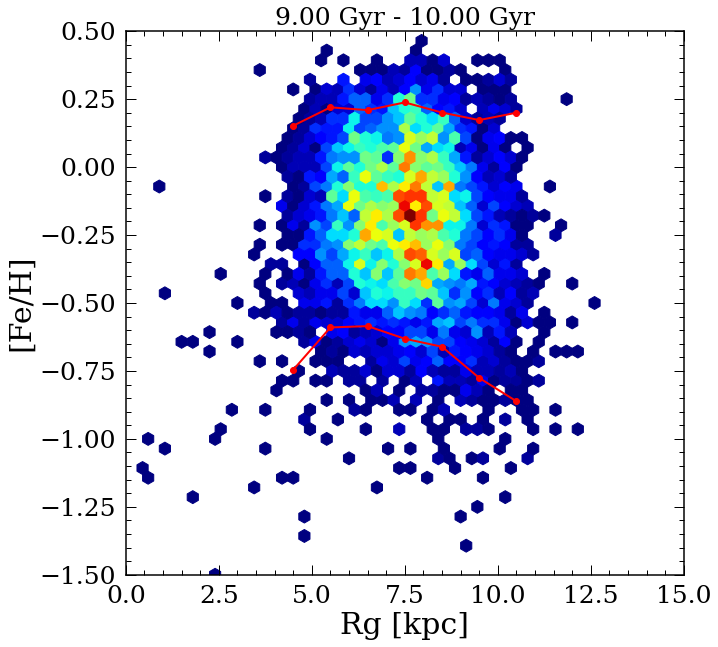

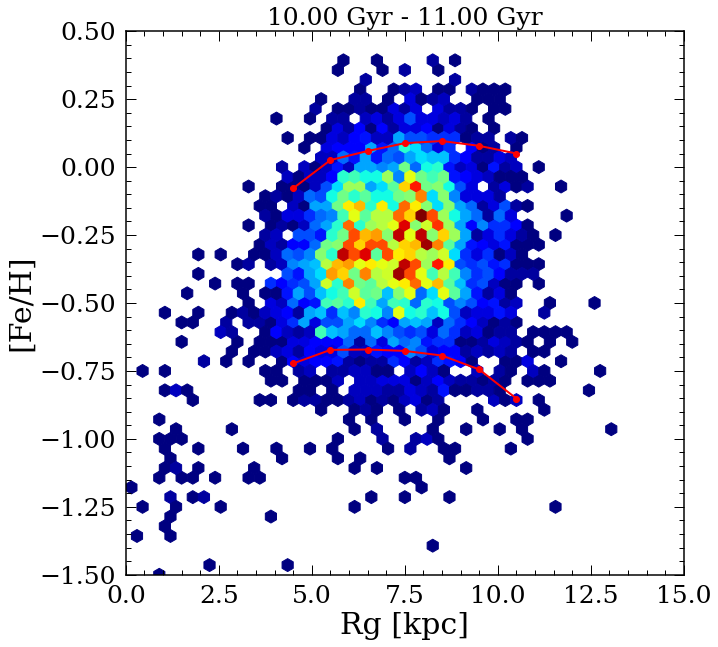

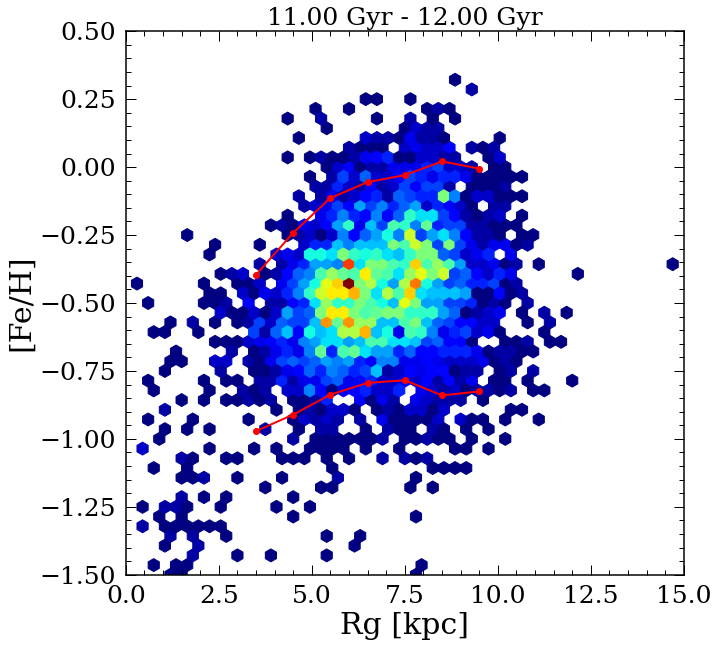

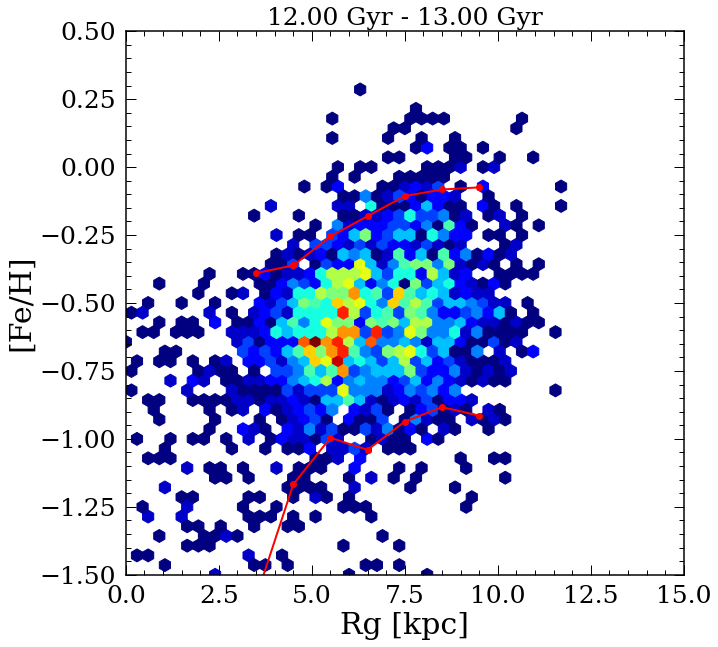

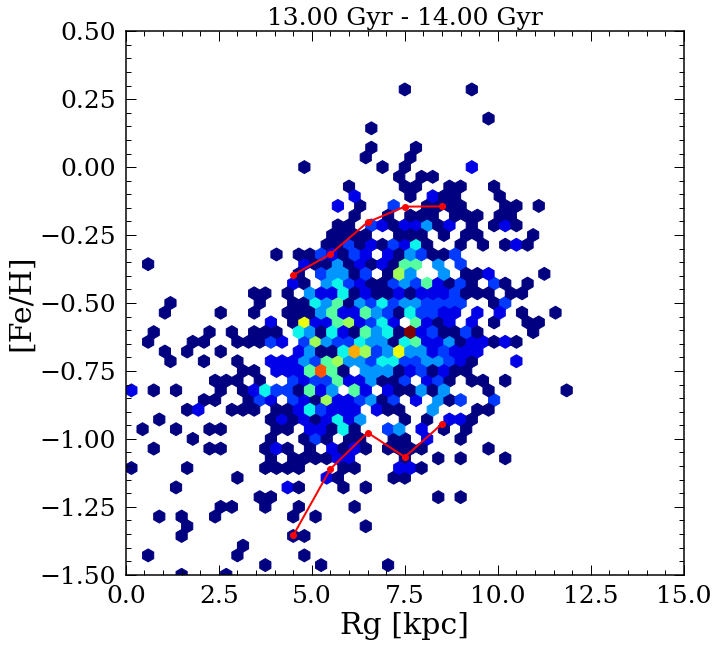

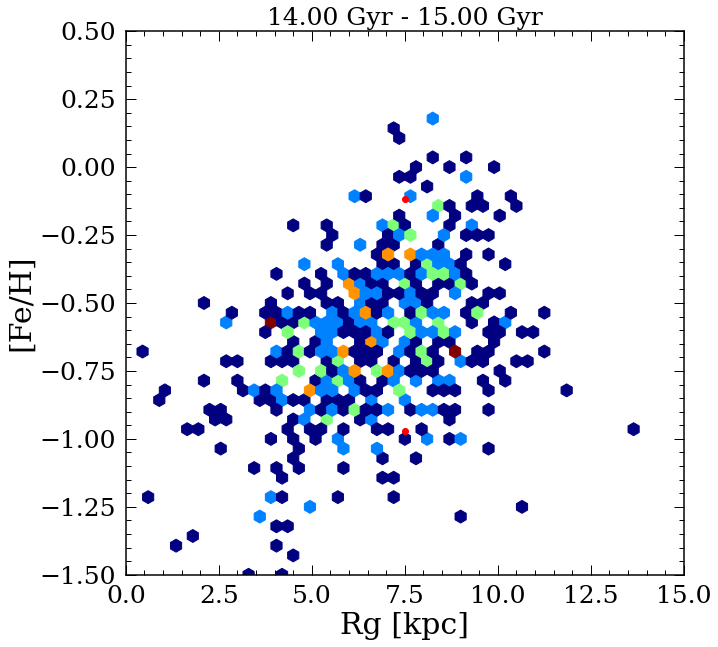

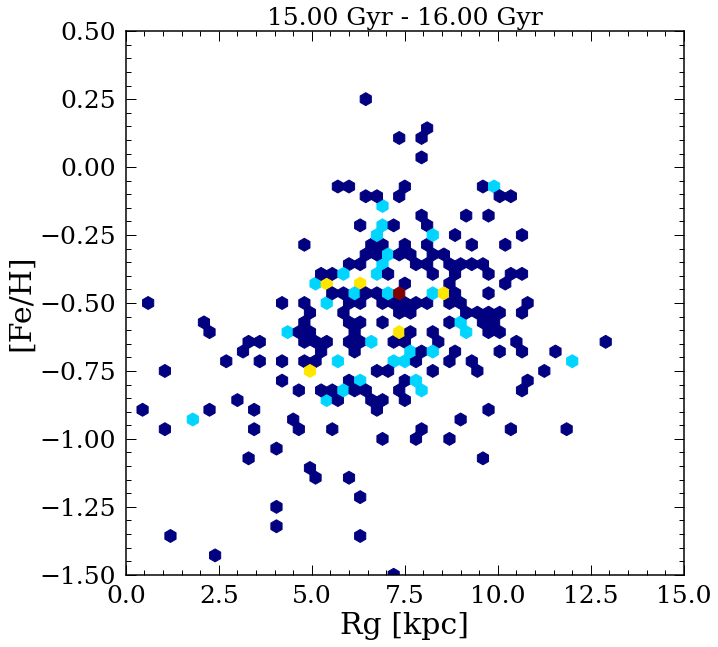

In [1404]:

agebincalc_rm = np.linspace(0,16,17)
rbins = np.linspace(0,15,16)
dr = np.zeros(len(agebincalc_rm)-1)

for i in trange(len(agebincalc_rm)-1):
    sub_tryRb_sing = sub_sel.loc[(sub_sel['AGE']>agebincalc_rm[i])&(sub_sel['AGE']<agebincalc_rm[i+1])]
    #mean_dr[i] = np.std(sub_tryRb_sing['Rb_new']-sub_tryRb_sing['R'])    
    #mean_dr_err[i] = mean_dr[i]/(len(sub_tryRb_sing)-1)
    plt.figure()
    """plt.plot(sub_tryRb_sing['R_GUIDING'], sub_tryRb_sing['FEH'],
              'ro',markersize=2)"""
    
    plt.hexbin(sub_tryRb_sing['R_GUIDING'], sub_tryRb_sing['FEH'],
              extent=(min(rbins), max(rbins),-1.5,0.5),
              cmap='jet',gridsize=50,mincnt=1)
    
    uplims = np.zeros(len(rbins)-1)*np.nan
    lowlims = np.zeros(len(rbins)-1)*np.nan
    for j in range(len(rbins)-1):
        Rsub = sub_tryRb_sing.loc[(sub_tryRb_sing['R_GUIDING']>rbins[j])&(sub_tryRb_sing['R_GUIDING']<rbins[j+1])]
        if len(Rsub)>100:
            uplims[j] = np.percentile(Rsub['FEH'],95)
            lowlims[j] = np.percentile(Rsub['FEH'],5)
            
    plt.plot(rbins[1:]/2+rbins[:-1]/2,
             uplims, 'ro-')
    plt.plot(rbins[1:]/2+rbins[:-1]/2,
             lowlims, 'ro-')
    plt.xlim([min(rbins), max(rbins)])
    plt.ylim([-1.5,0.5])
    plt.xlabel('Rg [kpc]')
    plt.ylabel('[Fe/H]')
    plt.title("%.2f Gyr - %.2f Gyr"%(agebincalc_rm[i],agebincalc_rm[i+1]),
             fontsize=25)
    """sub_tryRb_sing = sub_tryRb_sing.dropna(subset=['Rb_new'])
    dr[i] = np.std(sub_tryRb_sing['Rb_new'])"""
    
#plt.plot(agebincalc_rm[1:], dr, 'r-o')

    